# Coursework 2 - PyTorch based experiment framework

## Intro
Welcome to the coursework 2 PyTorch experiment framework. Pytorch is a  modern, intuitive, highly Pythonic and very fast framework for building differentiable graphs. Neural networks, as it happens, are a type of acyclic differentiable graph, so PyTorch is a great framework to use, if you want to build  complicated deep networks fairly easily.

## MLP package vs Pytorch
**Student**: So, why do I have to learn to use PyTorch now? I've spent all this time working on the MLP framework. Was that a waste of time?

**TA**: Well, Pytorch is everything the MLP package is, but faster, cleaner and far more resourceful. Since it is one of the main deep learning frameworks being used by industry and research alike, it has been fine-tuned quite a bit, to conform to the expectation of researchers and engineers alike. What this means, is that PyTorch is now a very robust and highly flexible package, that you can use for any project you want to work on in the future, if it involves trainining differentiable graphs. 

In addition, MLP is written in NumPy and your time working on it has taught some low level details of NNs; PyTorch was written to look as much as possible to NumPy, so it will feel very familiar to you. The skills you have acquired are highly transferable (that is, they generalize well, so not much overfitting there...). 

PyTorch will almost always have all the latest and greatest implemented in it as soon as they are released as papers, and if not, give it a week or two and someone will reproduce it. If you can't wait, you can reproduce it yourself and open source it. A great way to show your skills and get github likes. 

In addition PyTorch has Autograd! Automatic differentiation (previously mentioned in [lectures](http://www.inf.ed.ac.uk/teaching/courses/mlp/2018-19/mlp05-learn.pdf)). "What is this?" you may ask. Remember having to write all those backprop functions? Forget about it. Automatic differentiation allows you to backprop through any PyTorch operation you have used in your graph, by simply calling backward(). This [blog-post](https://jdhao.github.io/2017/11/12/pytorch-computation-graph/) explains how Pytorch's autograd works at an intuitive level.

**Student**: Why did we even have to use the MLP package? We did we even bother if such awesome frameworks are available?

**TA**: The purpose of the MLP package was not to allow you to build fast deep learning systems. Instead, it was to help teach you the low level mechanics and sensitivities of building a deep learning system. It allowed you to delve deep into how one can go about building a deep learning framework from scratch. The intuitions you have gained from going through your assignments and courseworks allow you to see deeper in what makes or breaks a deep learning system, at a level few people actually have. You are no longer restricted to the higher level modules provided by Pytorch/TensorFlow. 

If, for example, a new project required you to build something that does not exist in PyTorch/TensorFlow, or otherwise modify existing modules in a way that requires understanding and intuitions on backpropagation and layer/optimizer/component implementation, you would be able to do it much more easily than others who did not. You are now equipped to understand differentiable graphs, the chain rule, numerical errors, debugging at the lowest level and deep learning system architecture. 

In addition, by trying to implement your modules in an efficient way, you have also become aware of how to optimize a system for efficiency, and gave you intuitions on how one could further improve such a system (parallelization of implementations). 

Finally, the slowness of CPU training has allowed you to understand just how important modern GPU acceleration is, for deep learning research and applications. By coming across a large breadth of problems and understanding their origins, you will now be able to both anticipate and solve future problems in a more comprehensive way than someone who did not go through the trouble of implementing the basics from scratch. 

**Student**: If we are switching to Pytorch, then why bother implementing convolutions in the MLP package for the coursework?

**TA**: All your instructors, myself included, have found it greatly beneficial to implement convolutional networks from scratch. Once you implement convolutional layers, you will have a much deeper insight and understanding into how and why they work... as well as how they break. This way, you know what to do and what to avoid in the future. You might even be able to come with the next great network type yourself. 


## Getting Started

**Student**: So, how is the learning curve of Pytorch? How do I start?

**TA**: You can start by using this notebook on your experiments, it should teach you quite a lot on how to properly use PyTorch for basic conv net training. You should be aware of the [official pytorch github](https://github.com/pytorch/pytorch), the [pytorch official documentation page](https://pytorch.org/docs/stable/nn.html) and the [pytorch tutorials page](https://pytorch.org/tutorials/). 

Over the past year, nearly all students using PyTorch and Tensorflow on MLP and on projects found it easier and faster to get up to speed with PyTorch. In fact, I was a TensorFlow user myself, and learning TensorFlow was much more challenging than PyTorch. Mainly because TensorFlow has its own way of 'thinking' about how you build a graph and execute operations - whereas PyTorch is dynamic and works like NumPy, hence is more intuitive. If you were able to work well with the MLP package, you'll be up and running in no time. 

**Student**: OK, so how fast is pytorch compared to MLP?

**TA**: On the CPU side of things, you'll find pytorch at least 5x faster than the MLP framework (about equal for fully connected networks, but much faster for more complicated things like convolutions - unless you write extremely efficient convolutional layer code), and if you choose to use GPUs, either using MS Azure, Google Cloud or our very own MLP Cluster (available for next semester), you can expect, depending on implementation and hardware an approximate 25-70x speed ups, compared to the CPU performance of pytorch. Yes, that means an experiment that would run overnight, now would only require about 15 minutes.

**Student**: Ahh, where should I go to ask more questions?

**TA**: As always, start with a Google/DuckDuckGo search, then have a look at the PyTorch Github and PyTorch docs, and if you can't find the answer come to Piazza and the lab sessions. We will be there to support you.


#### Note: The code in this jupyter notebook is to introduce you to pytorch and allow you to play around with it in an interactive manner. However, to run your experiments, you should use the Pytorch experiment framework located in ```mlp/pytorch_experiment_scripts```. Instructions on how to use it can be found in ```notes/pytorch-experiment-framework.md``` along with the comments and documentation included in the code itself.

In [1]:
from torch import nn
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import tqdm
import os
import mlp.data_providers as data_providers
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def plot_stats_in_graph(total_losses):
    
    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in total_losses.keys():
        if "loss" in k:
            ax_1.plot(np.arange(len(total_losses[k])), total_losses[k], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    
    
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in total_losses.keys():
        if "acc" in k:
            ax_2.plot(np.arange(len(total_losses[k])), total_losses[k], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')

    plt.show()

In [3]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self, input_shape, dim_reduction_type, num_output_classes, num_filters, num_layers, use_bias=False):
        """
        Initializes a convolutional network module object.
        :param input_shape: The shape of the inputs going in to the network.
        :param dim_reduction_type: The type of dimensionality reduction to apply after each convolutional stage, should be one of ['max_pooling', 'avg_pooling', 'strided_convolution', 'dilated_convolution']
        :param num_output_classes: The number of outputs the network should have (for classification those would be the number of classes)
        :param num_filters: Number of filters used in every conv layer, except dim reduction stages, where those are automatically infered.
        :param num_layers: Number of conv layers (excluding dim reduction stages)
        :param use_bias: Whether our convolutions will use a bias.
        """
        super(ConvolutionalNetwork, self).__init__()
        # set up class attributes useful in building the network and inference
        self.input_shape = input_shape
        self.num_filters = num_filters
        self.num_output_classes = num_output_classes
        self.use_bias = use_bias
        self.num_layers = num_layers
        self.dim_reduction_type = dim_reduction_type
        # initialize a module dict, which is effectively a dictionary that can collect layers and integrate them into pytorch
        self.layer_dict = nn.ModuleDict()
        # build the network
        self.build_module()

    def build_module(self):
        """
        Builds network whilst automatically inferring shapes of layers.
        """
        print("Building basic block of ConvolutionalNetwork using input shape", self.input_shape)
        x = torch.zeros((self.input_shape)) # create dummy inputs to be used to infer shapes of layers

        out = x
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        for i in range(self.num_layers): # for number of layers times
            self.layer_dict['conv_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1], # add a conv layer in the module dict
                                                             kernel_size=3,
                                                             out_channels=self.num_filters, padding=1,
                                                             bias=self.use_bias)

            out = self.layer_dict['conv_{}'.format(i)](out) # use layer on inputs to get an output
            out = F.relu(out) # apply relu
            print(out.shape)
            if self.dim_reduction_type == 'strided_convolution': # if dim reduction is strided conv, then add a strided conv
                self.layer_dict['dim_reduction_strided_conv_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1],
                                                                                       kernel_size=3,
                                                                                       out_channels=out.shape[1],
                                                                                       padding=1,
                                                                                       bias=self.use_bias, stride=2,
                                                                                       dilation=1)

                out = self.layer_dict['dim_reduction_strided_conv_{}'.format(i)](out) # use strided conv to get an output
                out = F.relu(out) # apply relu to the output
            elif self.dim_reduction_type == 'dilated_convolution': # if dim reduction is dilated conv, then add a dilated conv, using an arbitrary dilation rate of i + 2 (so it gets smaller as we go, you can choose other dilation rates should you wish to do it.)
                self.layer_dict['dim_reduction_dilated_conv_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1],
                                                                                       kernel_size=3,
                                                                                       out_channels=out.shape[1],
                                                                                       padding=1,
                                                                                       bias=self.use_bias, stride=1,
                                                                                       dilation=i + 2)
                out = self.layer_dict['dim_reduction_dilated_conv_{}'.format(i)](out) # run dilated conv on input to get output
                out = F.relu(out) # apply relu on output

            elif self.dim_reduction_type == 'max_pooling':
                self.layer_dict['dim_reduction_max_pool_{}'.format(i)] = nn.MaxPool2d(2, padding=1)
                out = self.layer_dict['dim_reduction_max_pool_{}'.format(i)](out)

            elif self.dim_reduction_type == 'avg_pooling':
                self.layer_dict['dim_reduction_avg_pool_{}'.format(i)] = nn.AvgPool2d(2, padding=1)
                out = self.layer_dict['dim_reduction_avg_pool_{}'.format(i)](out)

            print(out.shape)

        out = F.adaptive_avg_pool2d(out, 2) # apply adaptive pooling to make sure output of conv layers is always (2, 2) spacially (helps with comparisons).
        print(out.shape)
        self.logits_linear_layer = nn.Linear(in_features=out.view(out.shape[0], -1).shape[1],  # add a linear layer
                                             out_features=self.num_output_classes,
                                             bias=self.use_bias)
        out = self.logits_linear_layer(out.view(out.shape[0], -1)) # apply linear layer on flattened inputs
        print("Block is built, output volume is", out.shape)
        return out

    def forward(self, x):
        """
        Forward propages the network given an input batch
        :param x: Inputs x (b, c, h, w)
        :return: preds (b, num_classes)
        """
        out = x
        for i in range(self.num_layers): # for number of layers

            out = self.layer_dict['conv_{}'.format(i)](out) # pass through conv layer indexed at i
            out = F.relu(out) # pass conv outputs through ReLU
            if self.dim_reduction_type == 'strided_convolution': # if strided convolution dim reduction then
                out = self.layer_dict['dim_reduction_strided_conv_{}'.format(i)](out) # pass previous outputs through a strided convolution indexed i
                out = F.relu(out) # pass strided conv outputs through ReLU

            elif self.dim_reduction_type == 'dilated_convolution':
                out = self.layer_dict['dim_reduction_dilated_conv_{}'.format(i)](out)
                out = F.relu(out)

            elif self.dim_reduction_type == 'max_pooling':
                out = self.layer_dict['dim_reduction_max_pool_{}'.format(i)](out)

            elif self.dim_reduction_type == 'avg_pooling':
                out = self.layer_dict['dim_reduction_avg_pool_{}'.format(i)](out)

        out = F.adaptive_avg_pool2d(out, 2)
        out = out.view(out.shape[0], -1) # flatten outputs from (b, c, h, w) to (b, c*h*w)
        out = self.logits_linear_layer(out) # pass through a linear layer to get logits/preds
        return out

    def reset_parameters(self):
        """
        Re-initialize the network parameters.
        """
        for item in self.layer_dict.children():
            try:
                item.reset_parameters()
            except:
                pass

        self.logits_linear_layer.reset_parameters()

In [4]:
import time
from mlp.pytorch_experiment_scripts.storage_utils import save_statistics
class ExperimentBuilder(nn.Module):
    def __init__(self, network_model, experiment_name, num_epochs, train_data, val_data,
                 test_data, weight_decay_coefficient, use_gpu, continue_from_epoch=-1):
        """
        Initializes an ExperimentBuilder object. Such an object takes care of running training and evaluation of a deep net
        on a given dataset. It also takes care of saving per epoch models and automatically inferring the best val model
        to be used for evaluating the test set metrics.
        :param network_model: A pytorch nn.Module which implements a network architecture.
        :param experiment_name: The name of the experiment. This is used mainly for keeping track of the experiment and creating and directory structure that will be used to save logs, model parameters and other.
        :param num_epochs: Total number of epochs to run the experiment
        :param train_data: An object of the DataProvider type. Contains the training set.
        :param val_data: An object of the DataProvider type. Contains the val set.
        :param test_data: An object of the DataProvider type. Contains the test set.
        :param weight_decay_coefficient: A float indicating the weight decay to use with the adam optimizer.
        :param use_gpu: A boolean indicating whether to use a GPU or not.
        :param continue_from_epoch: An int indicating whether we'll start from scrach (-1) or whether we'll reload a previously saved model of epoch 'continue_from_epoch' and continue training from there.
        """
        super(ExperimentBuilder, self).__init__()
        if torch.cuda.is_available() and use_gpu: # checks whether a cuda gpu is available and whether the gpu flag is True
            self.device = torch.device('cuda') # sets device to be cuda
            os.environ["CUDA_VISIBLE_DEVICES"] = "0" # sets the main GPU to be the one at index 0
            print("use GPU")
        else:
            print("use CPU")
            self.device = torch.device('cpu') # sets the device to be CPU

        self.experiment_name = experiment_name
        self.model = network_model
        self.model.to(self.device) # sends the model from the cpu to the gpu
        self.model.reset_parameters() # re-initialize network parameters
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.optimizer = optim.Adam(self.parameters(), amsgrad=False,
                                    weight_decay=weight_decay_coefficient)
        # Generate the directory names
        self.experiment_folder = os.path.abspath(experiment_name)
        self.experiment_logs = os.path.abspath(os.path.join(self.experiment_folder, "result_outputs"))
        self.experiment_saved_models = os.path.abspath(os.path.join(self.experiment_folder, "saved_models"))

        # Set best models to be at 0 since we are just starting
        self.best_val_model_idx = 0
        self.best_val_model_acc = 0.

        if not os.path.exists(self.experiment_folder): # If experiment directory does not exist
            os.mkdir(self.experiment_folder) # create the experiment directory
            os.mkdir(self.experiment_logs) # create the experiment log directory
            os.mkdir(self.experiment_saved_models) # create the experiment saved models directory

        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss().to(self.device) # send the loss computation to the GPU

        if continue_from_epoch != -1: # if continue from epoch is not -1 then
            self.best_val_model_idx, self.best_val_model_acc = self.load_model(
                model_save_dir=self.experiment_saved_models, model_save_name="train_model",
                model_idx=continue_from_epoch) # reload existing model from epoch and return best val model index
                                             # and the best val acc of that model
            self.starting_epoch = continue_from_epoch
        else:
            self.starting_epoch = 0

    def run_train_iter(self, x, y):
        """
        Receives the inputs and targets for the model and runs a training iteration. Returns loss and accuracy metrics.
        :param x: The inputs to the model. A numpy array of shape batch_size, channels, height, width
        :param y: The targets for the model. A numpy array of shape batch_size, num_classes
        :return: the loss and accuracy for this batch
        """
        self.train() # sets model to training mode (in case batch normalization or other methods have different procedures for training and evaluation)
        y = np.argmax(y, axis=1) # convert one hot encoded labels to single integer labels
        x, y = torch.Tensor(x).float().to(device=self.device), torch.Tensor(y).long().to(device=self.device) # send data to device as torch tensors
        out = self.model.forward(x) # forward the data in the model
        loss = F.cross_entropy(input=out, target=y) # compute loss

        self.optimizer.zero_grad() # set all weight grads from previous training iters to 0
        loss.backward() # backpropagate to compute gradients for current iter loss

        self.optimizer.step() # update network parameters
        _, predicted = torch.max(out.data, 1) # get argmax of predictions
        accuracy = np.mean(list(predicted.eq(y.data).cpu())) # compute accuracy
        return loss.data, accuracy

    def run_evaluation_iter(self, x, y):
        """
        Receives the inputs and targets for the model and runs an evaluation iterations. Returns loss and accuracy metrics.
        :param x: The inputs to the model. A numpy array of shape batch_size, channels, height, width
        :param y: The targets for the model. A numpy array of shape batch_size, num_classes
        :return: the loss and accuracy for this batch
        """
        self.eval() # sets the system to validation mode
        y = np.argmax(y, axis=1) # convert one hot encoded labels to single integer labels
        x, y = torch.Tensor(x).float().to(device=self.device), torch.Tensor(y).long().to(device=self.device) # convert data to pytorch tensors and send to the computation device
        out = self.model.forward(x) # forward the data in the model
        loss = F.cross_entropy(out, y) # compute loss
        _, predicted = torch.max(out.data, 1) # get argmax of predictions
        accuracy = np.mean(list(predicted.eq(y.data).cpu())) # compute accuracy
        return loss.data, accuracy

    def save_model(self, model_save_dir, model_save_name, model_idx, best_validation_model_idx,
                   best_validation_model_acc):
        """
        Save the network parameter state and current best val epoch idx and best val accuracy.
        :param model_save_name: Name to use to save model without the epoch index
        :param model_idx: The index to save the model with.
        :param best_validation_model_idx: The index of the best validation model to be stored for future use.
        :param best_validation_model_acc: The best validation accuracy to be stored for use at test time.
        :param model_save_dir: The directory to store the state at.
        :param state: The dictionary containing the system state.

        """
        state = dict()
        state['network'] = self.state_dict() # save network parameter and other variables.
        state['best_val_model_idx'] = best_validation_model_idx # save current best val idx
        state['best_val_model_acc'] = best_validation_model_acc # save current best val acc
        torch.save(state, f=os.path.join(model_save_dir, "{}_{}".format(model_save_name, str(model_idx)))) # save state at prespecified filepath

    def load_model(self, model_save_dir, model_save_name, model_idx):
        """
        Load the network parameter state and the best val model idx and best val acc to be compared with the future val accuracies, in order to choose the best val model
        :param model_save_dir: The directory to store the state at.
        :param model_save_name: Name to use to save model without the epoch index
        :param model_idx: The index to save the model with.
        :return: best val idx and best val model acc, also it loads the network state into the system state without returning it
        """
        state = torch.load(f=os.path.join(model_save_dir, "{}_{}".format(model_save_name, str(model_idx))))
        self.load_state_dict(state_dict=state['network'])
        return state['best_val_model_idx'], state['best_val_model_acc']

    def run_experiment(self):
        """
        Runs experiment train and evaluation iterations, saving the model and best val model and val model accuracy after each epoch
        :return: The summary current_epoch_losses from starting epoch to total_epochs.
        """
        total_losses = {"train_acc": [], "train_loss": [], "val_acc": [], "val_loss": []} # initialize a dict to keep the per-epoch metrics
        for i, epoch_idx in enumerate(range(self.starting_epoch, self.num_epochs)):
            epoch_start_time = time.time()
            current_epoch_losses = {"train_acc": [], "train_loss": [], "val_acc": [], "val_loss": []}

            with tqdm.tqdm(total=self.train_data.num_batches) as pbar_train: # create a progress bar for training
                for idx, (x, y) in enumerate(self.train_data): # get data batches
                    loss, accuracy = self.run_train_iter(x=x, y=y) # take a training iter step
                    current_epoch_losses["train_loss"].append(loss) # add current iter loss to the train loss list
                    current_epoch_losses["train_acc"].append(accuracy) # add current iter acc to the train acc list
                    pbar_train.update(1)
                    pbar_train.set_description("loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))

            with tqdm.tqdm(total=self.val_data.num_batches) as pbar_val: # create a progress bar for validation
                for x, y in self.val_data: # get data batches
                    loss, accuracy = self.run_evaluation_iter(x=x, y=y) # run a validation iter
                    current_epoch_losses["val_loss"].append(loss) # add current iter loss to val loss list.
                    current_epoch_losses["val_acc"].append(accuracy) # add current iter acc to val acc lst.
                    pbar_val.update(1) # add 1 step to the progress bar
                    pbar_val.set_description("loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))

            if np.mean(current_epoch_losses['val_acc']) > self.best_val_model_acc: # if current epoch's mean val acc is greater than the saved best val acc then
                self.best_val_model_acc = np.mean(current_epoch_losses['val_acc']) # set the best val model acc to be current epoch's val accuracy
                self.best_val_model_idx = epoch_idx # set the experiment-wise best val idx to be the current epoch's idx

            for key, value in current_epoch_losses.items():
                total_losses[key].append(np.mean(value)) # get mean of all metrics of current epoch metrics dict, to get them ready for storage and output on the terminal.

            save_statistics(experiment_log_dir=self.experiment_logs, filename='summary.csv',
                            stats_dict=total_losses, current_epoch=i) # save statistics to stats file.

            # load_statistics(experiment_log_dir=self.experiment_logs, filename='summary.csv') # How to load a csv file if you need to

            out_string = "_".join(["{}_{:.4f}".format(key, np.mean(value)) for key, value in current_epoch_losses.items()])
            # create a string to use to report our epoch metrics
            epoch_elapsed_time = time.time() - epoch_start_time # calculate time taken for epoch
            epoch_elapsed_time = "{:.4f}".format(epoch_elapsed_time)
            print("Epoch {}:".format(epoch_idx), out_string, "epoch time", epoch_elapsed_time, "seconds")
            self.save_model(model_save_dir=self.experiment_saved_models, # save model and best val idx and best val acc, using the model dir, model name and model idx
                            model_save_name="train_model", model_idx=epoch_idx,
                            best_validation_model_idx=self.best_val_model_idx,
                            best_validation_model_acc=self.best_val_model_acc)

        print("Generating test set evaluation metrics")
        self.load_model(model_save_dir=self.experiment_saved_models, model_idx=self.best_val_model_idx, # load best validation model
                        model_save_name="train_model")
        current_epoch_losses = {"test_acc": [], "test_loss": []} # initialize a statistics dict
        with tqdm.tqdm(total=self.test_data.num_batches) as pbar_test: # ini a progress bar
            for x, y in self.test_data: # sample batch
                loss, accuracy = self.run_evaluation_iter(x=x, y=y) # compute loss and accuracy by running an evaluation step
                current_epoch_losses["test_loss"].append(loss) # save test loss
                current_epoch_losses["test_acc"].append(accuracy) # save test accuracy
                pbar_test.update(1) # update progress bar status
                pbar_test.set_description("loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))  # update progress bar string output

        test_losses = {key: [np.mean(value)] for key, value in current_epoch_losses.items()} # save test set metrics in dict format
        save_statistics(experiment_log_dir=self.experiment_logs, filename='test_summary.csv', # save test set metrics on disk in .csv format
                        stats_dict=test_losses, current_epoch=0)

        return total_losses, test_losses


KeysView(<numpy.lib.npyio.NpzFile object at 0x7ff0d3bb08d0>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7ff0d3b88908>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7ff12bf224a8>)
Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 14, 14])
torch.Size([100, 64, 14, 14])
torch.Size([100, 64, 7, 7])
torch.Size([100, 64, 7, 7])
torch.Size([100, 64, 4, 4])
torch.Size([100, 64, 4, 4])
torch.Size([100, 64, 2, 2])
torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU


loss: 0.4635, accuracy: 0.8700:   0%|          | 5/1000 [00:00<00:23, 42.77it/s]

Epoch 0: train_acc_0.7604_train_loss_0.7671_val_acc_0.8513_val_loss_0.4294 epoch time 25.1779 seconds


loss: 0.3084, accuracy: 0.9200:   1%|          | 8/1000 [00:00<00:22, 43.98it/s]

Epoch 1: train_acc_0.8564_train_loss_0.4042_val_acc_0.8652_val_loss_0.3811 epoch time 25.5574 seconds


loss: 0.3237, accuracy: 0.8900:   1%|          | 8/1000 [00:00<00:22, 43.76it/s]

Epoch 2: train_acc_0.8738_train_loss_0.3477_val_acc_0.8749_val_loss_0.3512 epoch time 25.5944 seconds


loss: 0.3669, accuracy: 0.8800:   1%|          | 8/1000 [00:00<00:22, 43.19it/s]

Epoch 3: train_acc_0.8827_train_loss_0.3155_val_acc_0.8751_val_loss_0.3476 epoch time 25.6094 seconds


loss: 0.2168, accuracy: 0.9200:   1%|          | 8/1000 [00:00<00:22, 44.47it/s]

Epoch 4: train_acc_0.8891_train_loss_0.2932_val_acc_0.8747_val_loss_0.3513 epoch time 25.6194 seconds


loss: 0.1115, accuracy: 0.9600:   1%|          | 8/1000 [00:00<00:22, 43.82it/s]

Epoch 5: train_acc_0.8957_train_loss_0.2727_val_acc_0.8772_val_loss_0.3402 epoch time 25.5731 seconds


loss: 0.2089, accuracy: 0.9200:   1%|          | 8/1000 [00:00<00:22, 43.14it/s]

Epoch 6: train_acc_0.9010_train_loss_0.2540_val_acc_0.8846_val_loss_0.3356 epoch time 25.6246 seconds


loss: 0.2088, accuracy: 0.9100:   1%|          | 8/1000 [00:00<00:22, 43.59it/s]

Epoch 7: train_acc_0.9054_train_loss_0.2393_val_acc_0.8835_val_loss_0.3399 epoch time 25.6524 seconds


loss: 0.2077, accuracy: 0.8900:   1%|          | 8/1000 [00:00<00:22, 43.61it/s]

Epoch 8: train_acc_0.9103_train_loss_0.2239_val_acc_0.8809_val_loss_0.3389 epoch time 25.6811 seconds


loss: 0.1916, accuracy: 0.9000:   1%|          | 8/1000 [00:00<00:22, 44.31it/s]

Epoch 9: train_acc_0.9132_train_loss_0.2138_val_acc_0.8835_val_loss_0.3417 epoch time 25.6660 seconds


loss: 0.2467, accuracy: 0.8800:   1%|          | 8/1000 [00:00<00:23, 42.97it/s]

Epoch 10: train_acc_0.9169_train_loss_0.2033_val_acc_0.8825_val_loss_0.3619 epoch time 25.3628 seconds


loss: 0.1720, accuracy: 0.9200:   1%|          | 8/1000 [00:00<00:23, 42.88it/s]

Epoch 11: train_acc_0.9199_train_loss_0.1929_val_acc_0.8780_val_loss_0.3677 epoch time 25.6164 seconds


loss: 0.2021, accuracy: 0.9300:   1%|          | 8/1000 [00:00<00:22, 43.96it/s]

Epoch 12: train_acc_0.9258_train_loss_0.1796_val_acc_0.8857_val_loss_0.3740 epoch time 25.1614 seconds


loss: 0.1598, accuracy: 0.9300:   1%|          | 8/1000 [00:00<00:23, 43.01it/s]

Epoch 13: train_acc_0.9274_train_loss_0.1741_val_acc_0.8762_val_loss_0.4017 epoch time 25.6528 seconds


loss: 0.1062, accuracy: 0.9600:   1%|          | 8/1000 [00:00<00:23, 42.31it/s]

Epoch 14: train_acc_0.9299_train_loss_0.1671_val_acc_0.8828_val_loss_0.4214 epoch time 25.6024 seconds


loss: 0.0992, accuracy: 0.9400:   1%|          | 8/1000 [00:00<00:22, 43.88it/s]

Epoch 15: train_acc_0.9329_train_loss_0.1590_val_acc_0.8796_val_loss_0.4245 epoch time 25.6191 seconds


loss: 0.1104, accuracy: 0.9300:   1%|          | 8/1000 [00:00<00:22, 43.81it/s]

Epoch 16: train_acc_0.9351_train_loss_0.1548_val_acc_0.8832_val_loss_0.4381 epoch time 25.5703 seconds


loss: 0.1459, accuracy: 0.9400:   1%|          | 8/1000 [00:00<00:22, 43.22it/s]

Epoch 17: train_acc_0.9377_train_loss_0.1462_val_acc_0.8768_val_loss_0.4327 epoch time 25.6555 seconds


loss: 0.1227, accuracy: 0.9600:   1%|          | 8/1000 [00:00<00:22, 43.96it/s]

Epoch 18: train_acc_0.9398_train_loss_0.1414_val_acc_0.8754_val_loss_0.4471 epoch time 25.5296 seconds


loss: 0.0775, accuracy: 0.9600:   1%|          | 8/1000 [00:00<00:23, 42.51it/s]

Epoch 19: train_acc_0.9437_train_loss_0.1344_val_acc_0.8803_val_loss_0.4608 epoch time 25.6841 seconds


loss: 0.0603, accuracy: 0.9800:   1%|          | 8/1000 [00:00<00:23, 42.99it/s]

Epoch 20: train_acc_0.9453_train_loss_0.1301_val_acc_0.8784_val_loss_0.4701 epoch time 25.5544 seconds


loss: 0.1167, accuracy: 0.9600:   1%|          | 8/1000 [00:00<00:22, 43.82it/s]

Epoch 21: train_acc_0.9475_train_loss_0.1249_val_acc_0.8788_val_loss_0.5138 epoch time 25.6325 seconds


loss: 0.1939, accuracy: 0.9300:   1%|          | 8/1000 [00:00<00:22, 43.34it/s]

Epoch 22: train_acc_0.9481_train_loss_0.1229_val_acc_0.8784_val_loss_0.5218 epoch time 25.3161 seconds


loss: 0.1506, accuracy: 0.9600:   1%|          | 8/1000 [00:00<00:22, 43.61it/s]

Epoch 23: train_acc_0.9524_train_loss_0.1172_val_acc_0.8737_val_loss_0.5892 epoch time 25.6954 seconds


loss: 0.0747, accuracy: 0.9500:   1%|          | 8/1000 [00:00<00:21, 45.37it/s]

Epoch 24: train_acc_0.9527_train_loss_0.1129_val_acc_0.8749_val_loss_0.5530 epoch time 25.4350 seconds


loss: 0.0799, accuracy: 0.9700:   1%|          | 8/1000 [00:00<00:22, 43.66it/s]

Epoch 25: train_acc_0.9540_train_loss_0.1116_val_acc_0.8742_val_loss_0.5303 epoch time 25.5158 seconds


loss: 0.0864, accuracy: 0.9600:   1%|          | 8/1000 [00:00<00:22, 43.32it/s]

Epoch 26: train_acc_0.9559_train_loss_0.1079_val_acc_0.8727_val_loss_0.5613 epoch time 25.5543 seconds


loss: 0.1226, accuracy: 0.9500:   1%|          | 8/1000 [00:00<00:22, 43.22it/s]

Epoch 27: train_acc_0.9575_train_loss_0.1025_val_acc_0.8745_val_loss_0.5451 epoch time 25.6758 seconds


loss: 0.0210, accuracy: 1.0000:   1%|          | 8/1000 [00:00<00:23, 42.17it/s]

Epoch 28: train_acc_0.9585_train_loss_0.1015_val_acc_0.8704_val_loss_0.5866 epoch time 25.6188 seconds


loss: 0.0885, accuracy: 0.9700:   1%|          | 8/1000 [00:00<00:22, 43.79it/s]

Epoch 29: train_acc_0.9586_train_loss_0.1006_val_acc_0.8728_val_loss_0.6227 epoch time 25.6536 seconds


loss: 0.0944, accuracy: 0.9500:   1%|          | 8/1000 [00:00<00:22, 44.34it/s]

Epoch 30: train_acc_0.9606_train_loss_0.0968_val_acc_0.8742_val_loss_0.6489 epoch time 25.5615 seconds


loss: 0.0706, accuracy: 0.9800:   1%|          | 8/1000 [00:00<00:22, 43.34it/s]

Epoch 31: train_acc_0.9629_train_loss_0.0903_val_acc_0.8707_val_loss_0.6235 epoch time 25.5894 seconds


loss: 0.0485, accuracy: 0.9800:   1%|          | 8/1000 [00:00<00:22, 43.93it/s]

Epoch 32: train_acc_0.9620_train_loss_0.0937_val_acc_0.8740_val_loss_0.6334 epoch time 25.4417 seconds


loss: 0.0302, accuracy: 0.9900:   1%|          | 8/1000 [00:00<00:22, 44.60it/s]

Epoch 33: train_acc_0.9637_train_loss_0.0880_val_acc_0.8736_val_loss_0.6573 epoch time 25.6680 seconds


loss: 0.0439, accuracy: 0.9800:   1%|          | 8/1000 [00:00<00:23, 42.38it/s]

Epoch 34: train_acc_0.9656_train_loss_0.0864_val_acc_0.8720_val_loss_0.7040 epoch time 25.4004 seconds


loss: 0.1256, accuracy: 0.9400:   1%|          | 8/1000 [00:00<00:23, 42.30it/s]

Epoch 35: train_acc_0.9656_train_loss_0.0849_val_acc_0.8739_val_loss_0.6545 epoch time 25.5848 seconds


loss: 0.0645, accuracy: 0.9800:   1%|          | 8/1000 [00:00<00:22, 44.90it/s]

Epoch 36: train_acc_0.9673_train_loss_0.0824_val_acc_0.8685_val_loss_0.6641 epoch time 25.5702 seconds


loss: 0.0843, accuracy: 0.9600:   1%|          | 8/1000 [00:00<00:22, 43.54it/s]

Epoch 37: train_acc_0.9679_train_loss_0.0809_val_acc_0.8748_val_loss_0.6693 epoch time 25.3987 seconds


loss: 0.0823, accuracy: 0.9600:   1%|          | 8/1000 [00:00<00:22, 43.19it/s]

Epoch 38: train_acc_0.9684_train_loss_0.0788_val_acc_0.8713_val_loss_0.6798 epoch time 25.5530 seconds


loss: 0.0522, accuracy: 0.9800:   1%|          | 8/1000 [00:00<00:22, 43.19it/s]

Epoch 39: train_acc_0.9696_train_loss_0.0765_val_acc_0.8703_val_loss_0.7446 epoch time 25.6415 seconds


loss: 0.0775, accuracy: 0.9600:   1%|          | 8/1000 [00:00<00:22, 44.14it/s]

Epoch 40: train_acc_0.9706_train_loss_0.0746_val_acc_0.8706_val_loss_0.7253 epoch time 25.6160 seconds


loss: 0.0188, accuracy: 1.0000:   1%|          | 8/1000 [00:00<00:23, 42.92it/s]

Epoch 41: train_acc_0.9712_train_loss_0.0727_val_acc_0.8734_val_loss_0.7764 epoch time 25.6414 seconds


loss: 0.0301, accuracy: 0.9900:   1%|          | 8/1000 [00:00<00:23, 42.75it/s]

Epoch 42: train_acc_0.9719_train_loss_0.0713_val_acc_0.8716_val_loss_0.7273 epoch time 25.5861 seconds


loss: 0.0553, accuracy: 0.9700:   1%|          | 8/1000 [00:00<00:22, 43.91it/s]

Epoch 43: train_acc_0.9706_train_loss_0.0730_val_acc_0.8701_val_loss_0.7172 epoch time 25.6072 seconds


loss: 0.0962, accuracy: 0.9700:   1%|          | 8/1000 [00:00<00:22, 43.82it/s]

Epoch 44: train_acc_0.9741_train_loss_0.0667_val_acc_0.8719_val_loss_0.6761 epoch time 25.6673 seconds


loss: 0.0580, accuracy: 0.9800:   1%|          | 8/1000 [00:00<00:22, 45.06it/s]

Epoch 45: train_acc_0.9736_train_loss_0.0668_val_acc_0.8712_val_loss_0.7880 epoch time 25.4508 seconds


loss: 0.1050, accuracy: 0.9700:   1%|          | 8/1000 [00:00<00:22, 43.18it/s]

Epoch 46: train_acc_0.9739_train_loss_0.0649_val_acc_0.8718_val_loss_0.7871 epoch time 25.2574 seconds


loss: 0.0594, accuracy: 0.9700:   1%|          | 8/1000 [00:00<00:22, 43.79it/s]

Epoch 47: train_acc_0.9753_train_loss_0.0636_val_acc_0.8690_val_loss_0.8309 epoch time 25.5250 seconds


loss: 0.1387, accuracy: 0.9500:   1%|          | 8/1000 [00:00<00:22, 44.20it/s]

Epoch 48: train_acc_0.9752_train_loss_0.0645_val_acc_0.8706_val_loss_0.8007 epoch time 25.5857 seconds


loss: 0.0248, accuracy: 0.9900:   1%|          | 8/1000 [00:00<00:22, 43.54it/s]

Epoch 49: train_acc_0.9761_train_loss_0.0625_val_acc_0.8708_val_loss_0.8581 epoch time 25.2238 seconds


loss: 0.0603, accuracy: 0.9900:   1%|          | 8/1000 [00:00<00:22, 44.41it/s]

Epoch 50: train_acc_0.9765_train_loss_0.0605_val_acc_0.8725_val_loss_0.7994 epoch time 25.4899 seconds


loss: 0.0461, accuracy: 0.9800:   1%|          | 8/1000 [00:00<00:22, 44.24it/s]

Epoch 51: train_acc_0.9764_train_loss_0.0614_val_acc_0.8680_val_loss_0.7476 epoch time 25.5937 seconds


loss: 0.0342, accuracy: 0.9900:   1%|          | 8/1000 [00:00<00:22, 43.88it/s]

Epoch 52: train_acc_0.9770_train_loss_0.0590_val_acc_0.8735_val_loss_0.8345 epoch time 25.5343 seconds


loss: 0.0697, accuracy: 0.9800:   1%|          | 8/1000 [00:00<00:22, 43.69it/s]

Epoch 53: train_acc_0.9791_train_loss_0.0556_val_acc_0.8722_val_loss_0.8398 epoch time 25.5642 seconds


loss: 0.0421, accuracy: 0.9800:   1%|          | 8/1000 [00:00<00:22, 44.35it/s]

Epoch 54: train_acc_0.9778_train_loss_0.0584_val_acc_0.8672_val_loss_0.8889 epoch time 25.5868 seconds


loss: 0.0401, accuracy: 0.9800:   1%|          | 8/1000 [00:00<00:22, 44.29it/s]

Epoch 55: train_acc_0.9796_train_loss_0.0534_val_acc_0.8680_val_loss_0.8387 epoch time 25.6371 seconds


loss: 0.0589, accuracy: 0.9800:   1%|          | 8/1000 [00:00<00:22, 43.89it/s]

Epoch 56: train_acc_0.9791_train_loss_0.0556_val_acc_0.8677_val_loss_0.7507 epoch time 25.4874 seconds


loss: 0.0528, accuracy: 0.9800:   1%|          | 8/1000 [00:00<00:22, 44.28it/s]

Epoch 57: train_acc_0.9778_train_loss_0.0574_val_acc_0.8686_val_loss_0.8702 epoch time 25.5192 seconds


loss: 0.0219, accuracy: 0.9900:   1%|          | 8/1000 [00:00<00:22, 44.51it/s]

Epoch 58: train_acc_0.9803_train_loss_0.0525_val_acc_0.8693_val_loss_0.8178 epoch time 25.4566 seconds


loss: 0.1179, accuracy: 0.9700:   1%|          | 8/1000 [00:00<00:22, 43.43it/s]

Epoch 59: train_acc_0.9811_train_loss_0.0508_val_acc_0.8723_val_loss_0.8150 epoch time 25.5442 seconds


loss: 0.0195, accuracy: 1.0000:   1%|          | 8/1000 [00:00<00:22, 43.55it/s]

Epoch 60: train_acc_0.9808_train_loss_0.0514_val_acc_0.8682_val_loss_0.8853 epoch time 25.5160 seconds


loss: 0.0293, accuracy: 0.9800:   1%|          | 8/1000 [00:00<00:22, 43.64it/s]

Epoch 61: train_acc_0.9819_train_loss_0.0488_val_acc_0.8662_val_loss_0.8848 epoch time 25.0490 seconds


loss: 0.0660, accuracy: 0.9700:   1%|          | 8/1000 [00:00<00:22, 44.05it/s]

Epoch 62: train_acc_0.9823_train_loss_0.0478_val_acc_0.8667_val_loss_0.8914 epoch time 25.4189 seconds


loss: 0.0243, accuracy: 0.9900:   1%|          | 8/1000 [00:00<00:22, 43.31it/s]

Epoch 63: train_acc_0.9821_train_loss_0.0494_val_acc_0.8713_val_loss_0.8685 epoch time 25.4364 seconds


loss: 0.0068, accuracy: 1.0000:   1%|          | 8/1000 [00:00<00:23, 43.01it/s]

Epoch 64: train_acc_0.9818_train_loss_0.0495_val_acc_0.8686_val_loss_0.9163 epoch time 25.4701 seconds


loss: 0.0167, accuracy: 0.9900:   1%|          | 8/1000 [00:00<00:22, 44.39it/s]

Epoch 65: train_acc_0.9827_train_loss_0.0473_val_acc_0.8663_val_loss_0.8304 epoch time 25.5013 seconds


loss: 0.0557, accuracy: 0.9800:   1%|          | 8/1000 [00:00<00:22, 43.27it/s]

Epoch 66: train_acc_0.9828_train_loss_0.0468_val_acc_0.8711_val_loss_0.9099 epoch time 25.5252 seconds


loss: 0.0191, accuracy: 0.9900:   1%|          | 8/1000 [00:00<00:22, 43.34it/s]

Epoch 67: train_acc_0.9829_train_loss_0.0468_val_acc_0.8682_val_loss_0.9460 epoch time 25.5069 seconds


loss: 0.0723, accuracy: 0.9800:   1%|          | 8/1000 [00:00<00:22, 44.23it/s]

Epoch 68: train_acc_0.9840_train_loss_0.0443_val_acc_0.8706_val_loss_0.9324 epoch time 25.4628 seconds


loss: 0.0114, accuracy: 1.0000:   1%|          | 8/1000 [00:00<00:22, 43.97it/s]

Epoch 69: train_acc_0.9830_train_loss_0.0462_val_acc_0.8677_val_loss_0.8324 epoch time 25.5418 seconds


loss: 0.0387, accuracy: 0.9800:   1%|          | 8/1000 [00:00<00:22, 43.35it/s]

Epoch 70: train_acc_0.9839_train_loss_0.0447_val_acc_0.8692_val_loss_0.9334 epoch time 25.3123 seconds


loss: 0.0285, accuracy: 0.9800:   1%|          | 8/1000 [00:00<00:22, 44.10it/s]

Epoch 71: train_acc_0.9846_train_loss_0.0429_val_acc_0.8680_val_loss_0.8439 epoch time 25.5241 seconds


loss: 0.0262, accuracy: 0.9900:   1%|          | 8/1000 [00:00<00:22, 44.47it/s]

Epoch 72: train_acc_0.9836_train_loss_0.0455_val_acc_0.8672_val_loss_0.9364 epoch time 25.6355 seconds


loss: 0.0339, accuracy: 0.9900:   1%|          | 8/1000 [00:00<00:22, 43.59it/s]

Epoch 73: train_acc_0.9846_train_loss_0.0430_val_acc_0.8701_val_loss_0.8370 epoch time 25.0172 seconds


loss: 0.0639, accuracy: 0.9900:   1%|          | 8/1000 [00:00<00:22, 44.09it/s]

Epoch 74: train_acc_0.9856_train_loss_0.0397_val_acc_0.8676_val_loss_0.8884 epoch time 25.5246 seconds


loss: 0.0274, accuracy: 0.9900:   1%|          | 8/1000 [00:00<00:22, 43.44it/s]

Epoch 75: train_acc_0.9834_train_loss_0.0464_val_acc_0.8709_val_loss_0.9433 epoch time 25.4953 seconds


loss: 0.0142, accuracy: 0.9900:   1%|          | 8/1000 [00:00<00:22, 43.70it/s]

Epoch 76: train_acc_0.9849_train_loss_0.0418_val_acc_0.8695_val_loss_0.9702 epoch time 25.5602 seconds


loss: 0.0995, accuracy: 0.9700:   1%|          | 8/1000 [00:00<00:22, 43.18it/s]

Epoch 77: train_acc_0.9853_train_loss_0.0397_val_acc_0.8736_val_loss_0.9170 epoch time 25.5407 seconds


loss: 0.0589, accuracy: 0.9800:   1%|          | 8/1000 [00:00<00:22, 43.61it/s]

Epoch 78: train_acc_0.9844_train_loss_0.0430_val_acc_0.8696_val_loss_0.8881 epoch time 25.3162 seconds


loss: 0.0214, accuracy: 1.0000:   1%|          | 8/1000 [00:00<00:22, 44.11it/s]

Epoch 79: train_acc_0.9862_train_loss_0.0384_val_acc_0.8724_val_loss_0.9695 epoch time 25.3863 seconds


loss: 0.0216, accuracy: 0.9900:   1%|          | 8/1000 [00:00<00:22, 43.51it/s]

Epoch 80: train_acc_0.9856_train_loss_0.0403_val_acc_0.8727_val_loss_1.0363 epoch time 25.4963 seconds


loss: 0.0433, accuracy: 0.9900:   1%|          | 8/1000 [00:00<00:22, 44.22it/s]

Epoch 81: train_acc_0.9864_train_loss_0.0383_val_acc_0.8689_val_loss_0.8449 epoch time 25.4188 seconds


loss: 0.0265, accuracy: 0.9900:   1%|          | 8/1000 [00:00<00:22, 43.82it/s]

Epoch 82: train_acc_0.9866_train_loss_0.0377_val_acc_0.8719_val_loss_0.9494 epoch time 25.4264 seconds


loss: 0.0041, accuracy: 1.0000:   1%|          | 8/1000 [00:00<00:23, 42.85it/s]

Epoch 83: train_acc_0.9862_train_loss_0.0402_val_acc_0.8720_val_loss_0.9301 epoch time 25.5588 seconds


loss: 0.0167, accuracy: 1.0000:   1%|          | 8/1000 [00:00<00:22, 44.15it/s]

Epoch 84: train_acc_0.9862_train_loss_0.0384_val_acc_0.8670_val_loss_0.9207 epoch time 25.5503 seconds


loss: 0.0286, accuracy: 0.9800:   1%|          | 8/1000 [00:00<00:22, 43.30it/s]

Epoch 85: train_acc_0.9871_train_loss_0.0368_val_acc_0.8722_val_loss_0.9832 epoch time 25.0073 seconds


loss: 0.0201, accuracy: 1.0000:   1%|          | 8/1000 [00:00<00:23, 42.96it/s]

Epoch 86: train_acc_0.9859_train_loss_0.0401_val_acc_0.8694_val_loss_0.9900 epoch time 25.5194 seconds


loss: 0.0041, accuracy: 1.0000:   1%|          | 8/1000 [00:00<00:22, 43.15it/s]

Epoch 87: train_acc_0.9856_train_loss_0.0399_val_acc_0.8695_val_loss_0.9157 epoch time 25.6098 seconds


loss: 0.0113, accuracy: 1.0000:   1%|          | 8/1000 [00:00<00:22, 44.46it/s]

Epoch 88: train_acc_0.9879_train_loss_0.0354_val_acc_0.8692_val_loss_1.0185 epoch time 25.2773 seconds


loss: 0.0399, accuracy: 0.9900:   1%|          | 8/1000 [00:00<00:22, 43.75it/s]

Epoch 89: train_acc_0.9864_train_loss_0.0388_val_acc_0.8664_val_loss_0.9405 epoch time 25.4993 seconds


loss: 0.0490, accuracy: 0.9700:   1%|          | 8/1000 [00:00<00:22, 43.75it/s]

Epoch 90: train_acc_0.9878_train_loss_0.0347_val_acc_0.8674_val_loss_0.9207 epoch time 25.5483 seconds


loss: 0.0050, accuracy: 1.0000:   1%|          | 8/1000 [00:00<00:23, 43.06it/s]

Epoch 91: train_acc_0.9863_train_loss_0.0393_val_acc_0.8678_val_loss_1.0175 epoch time 25.6471 seconds


loss: 0.0154, accuracy: 1.0000:   1%|          | 8/1000 [00:00<00:22, 43.40it/s]

Epoch 92: train_acc_0.9869_train_loss_0.0373_val_acc_0.8739_val_loss_1.0301 epoch time 25.5320 seconds


loss: 0.0693, accuracy: 0.9700:   1%|          | 8/1000 [00:00<00:21, 45.17it/s]

Epoch 93: train_acc_0.9873_train_loss_0.0375_val_acc_0.8653_val_loss_1.0048 epoch time 25.4997 seconds


loss: 0.0143, accuracy: 0.9900:   1%|          | 8/1000 [00:00<00:22, 44.17it/s]

Epoch 94: train_acc_0.9871_train_loss_0.0376_val_acc_0.8673_val_loss_0.9292 epoch time 25.5136 seconds


loss: 0.0494, accuracy: 0.9700:   1%|          | 8/1000 [00:00<00:22, 43.53it/s]

Epoch 95: train_acc_0.9879_train_loss_0.0343_val_acc_0.8660_val_loss_1.0272 epoch time 25.6035 seconds


loss: 0.0157, accuracy: 0.9900:   1%|          | 8/1000 [00:00<00:22, 44.18it/s]

Epoch 96: train_acc_0.9870_train_loss_0.0378_val_acc_0.8696_val_loss_0.9795 epoch time 25.6871 seconds


loss: 0.0397, accuracy: 0.9900:   1%|          | 8/1000 [00:00<00:22, 44.42it/s]

Epoch 97: train_acc_0.9879_train_loss_0.0343_val_acc_0.8697_val_loss_0.9392 epoch time 25.3819 seconds


loss: 0.0072, accuracy: 1.0000:   1%|          | 8/1000 [00:00<00:22, 43.56it/s]

Epoch 98: train_acc_0.9876_train_loss_0.0351_val_acc_0.8661_val_loss_0.9898 epoch time 25.4289 seconds


loss: 0.2974, accuracy: 0.8900:  13%|█▎        | 20/158 [00:00<00:01, 113.40it/s]

Epoch 99: train_acc_0.9878_train_loss_0.0345_val_acc_0.8695_val_loss_1.0354 epoch time 25.5014 seconds
Generating test set evaluation metrics


loss: 0.5295, accuracy: 0.8300: 100%|██████████| 158/158 [00:01<00:00, 101.20it/s]


finish


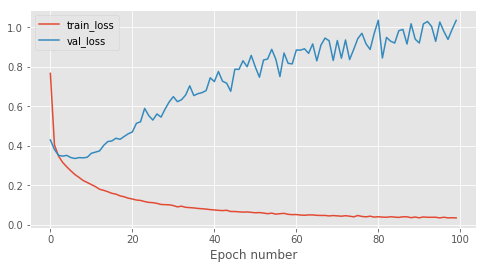

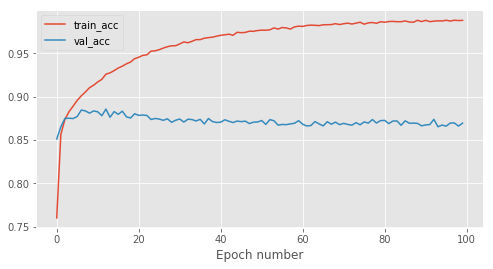

Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 26, 26])
torch.Size([100, 64, 26, 26])
torch.Size([100, 64, 22, 22])
torch.Size([100, 64, 22, 22])
torch.Size([100, 64, 16, 16])


loss: 3.8501, accuracy: 0.0300:   0%|          | 2/1000 [00:00<01:07, 14.88it/s]

torch.Size([100, 64, 16, 16])
torch.Size([100, 64, 8, 8])
torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU


loss: 0.3985, accuracy: 0.8400:   0%|          | 3/1000 [00:00<00:58, 16.98it/s]

Epoch 0: train_acc_0.7548_train_loss_0.7834_val_acc_0.8559_val_loss_0.4231 epoch time 65.3835 seconds


loss: 0.3140, accuracy: 0.9100:   0%|          | 3/1000 [00:00<00:56, 17.49it/s]

Epoch 1: train_acc_0.8605_train_loss_0.3939_val_acc_0.8639_val_loss_0.3573 epoch time 65.2866 seconds


loss: 0.2878, accuracy: 0.8900:   0%|          | 3/1000 [00:00<00:59, 16.87it/s]

Epoch 2: train_acc_0.8758_train_loss_0.3428_val_acc_0.8778_val_loss_0.3578 epoch time 65.1520 seconds


loss: 0.1994, accuracy: 0.9400:   0%|          | 3/1000 [00:00<00:59, 16.90it/s]

Epoch 3: train_acc_0.8839_train_loss_0.3127_val_acc_0.8861_val_loss_0.3182 epoch time 64.9560 seconds


loss: 0.2146, accuracy: 0.9100:   0%|          | 3/1000 [00:00<00:57, 17.38it/s]

Epoch 4: train_acc_0.8905_train_loss_0.2902_val_acc_0.8859_val_loss_0.3195 epoch time 65.1379 seconds


loss: 0.2837, accuracy: 0.9000:   0%|          | 3/1000 [00:00<00:59, 16.89it/s]

Epoch 5: train_acc_0.8962_train_loss_0.2725_val_acc_0.8894_val_loss_0.3032 epoch time 65.0746 seconds


loss: 0.1715, accuracy: 0.9600:   0%|          | 3/1000 [00:00<00:57, 17.28it/s]

Epoch 6: train_acc_0.8999_train_loss_0.2586_val_acc_0.8892_val_loss_0.3060 epoch time 64.9852 seconds


loss: 0.2641, accuracy: 0.8700:   0%|          | 3/1000 [00:00<00:57, 17.44it/s]

Epoch 7: train_acc_0.9052_train_loss_0.2442_val_acc_0.8876_val_loss_0.3067 epoch time 64.9966 seconds


loss: 0.1879, accuracy: 0.9200:   0%|          | 3/1000 [00:00<00:59, 16.81it/s]

Epoch 8: train_acc_0.9091_train_loss_0.2311_val_acc_0.8913_val_loss_0.3141 epoch time 64.7491 seconds


loss: 0.2330, accuracy: 0.9200:   0%|          | 3/1000 [00:00<00:59, 16.81it/s]

Epoch 9: train_acc_0.9123_train_loss_0.2188_val_acc_0.8861_val_loss_0.3231 epoch time 64.8851 seconds


loss: 0.1153, accuracy: 0.9300:   0%|          | 3/1000 [00:00<00:58, 17.14it/s]

Epoch 10: train_acc_0.9170_train_loss_0.2059_val_acc_0.8921_val_loss_0.3418 epoch time 64.8769 seconds


loss: 0.1523, accuracy: 0.9500:   0%|          | 3/1000 [00:00<00:58, 16.94it/s]

Epoch 11: train_acc_0.9190_train_loss_0.1998_val_acc_0.8889_val_loss_0.3293 epoch time 64.7772 seconds


loss: 0.1668, accuracy: 0.9200:   0%|          | 3/1000 [00:00<00:57, 17.24it/s]

Epoch 12: train_acc_0.9226_train_loss_0.1889_val_acc_0.8863_val_loss_0.3460 epoch time 64.8448 seconds


loss: 0.1761, accuracy: 0.9100:   0%|          | 3/1000 [00:00<00:58, 17.09it/s]

Epoch 13: train_acc_0.9267_train_loss_0.1784_val_acc_0.8870_val_loss_0.3473 epoch time 64.5261 seconds


loss: 0.1514, accuracy: 0.9400:   0%|          | 3/1000 [00:00<00:59, 16.84it/s]

Epoch 14: train_acc_0.9302_train_loss_0.1688_val_acc_0.8880_val_loss_0.3481 epoch time 64.8041 seconds


loss: 0.1636, accuracy: 0.9300:   0%|          | 3/1000 [00:00<00:59, 16.85it/s]

Epoch 15: train_acc_0.9337_train_loss_0.1599_val_acc_0.8858_val_loss_0.3908 epoch time 64.7933 seconds


loss: 0.1205, accuracy: 0.9400:   0%|          | 3/1000 [00:00<00:58, 16.91it/s]

Epoch 16: train_acc_0.9359_train_loss_0.1518_val_acc_0.8807_val_loss_0.3897 epoch time 64.6204 seconds


loss: 0.0665, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:57, 17.32it/s]

Epoch 17: train_acc_0.9402_train_loss_0.1446_val_acc_0.8772_val_loss_0.4264 epoch time 64.7678 seconds


loss: 0.2040, accuracy: 0.9000:   0%|          | 3/1000 [00:00<00:59, 16.88it/s]

Epoch 18: train_acc_0.9420_train_loss_0.1380_val_acc_0.8823_val_loss_0.4281 epoch time 64.5348 seconds


loss: 0.1736, accuracy: 0.9500:   0%|          | 3/1000 [00:00<00:57, 17.33it/s]

Epoch 19: train_acc_0.9460_train_loss_0.1304_val_acc_0.8797_val_loss_0.4575 epoch time 64.7122 seconds


loss: 0.0950, accuracy: 0.9600:   0%|          | 3/1000 [00:00<00:58, 16.90it/s]

Epoch 20: train_acc_0.9484_train_loss_0.1240_val_acc_0.8810_val_loss_0.4824 epoch time 64.7016 seconds


loss: 0.1391, accuracy: 0.9200:   0%|          | 3/1000 [00:00<00:57, 17.33it/s]

Epoch 21: train_acc_0.9508_train_loss_0.1185_val_acc_0.8779_val_loss_0.4899 epoch time 64.4785 seconds


loss: 0.0995, accuracy: 0.9700:   0%|          | 3/1000 [00:00<00:57, 17.40it/s]

Epoch 22: train_acc_0.9525_train_loss_0.1137_val_acc_0.8792_val_loss_0.4855 epoch time 64.6233 seconds


loss: 0.1075, accuracy: 0.9500:   0%|          | 3/1000 [00:00<00:58, 16.92it/s]

Epoch 23: train_acc_0.9559_train_loss_0.1078_val_acc_0.8774_val_loss_0.5029 epoch time 64.3987 seconds


loss: 0.1532, accuracy: 0.9300:   0%|          | 3/1000 [00:00<00:57, 17.41it/s]

Epoch 24: train_acc_0.9576_train_loss_0.1035_val_acc_0.8777_val_loss_0.5340 epoch time 64.5918 seconds


loss: 0.0658, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:58, 16.95it/s]

Epoch 25: train_acc_0.9600_train_loss_0.0989_val_acc_0.8769_val_loss_0.5589 epoch time 64.4425 seconds


loss: 0.0275, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:57, 17.37it/s]

Epoch 26: train_acc_0.9603_train_loss_0.0971_val_acc_0.8777_val_loss_0.5715 epoch time 64.6243 seconds


loss: 0.0592, accuracy: 0.9700:   0%|          | 3/1000 [00:00<00:58, 16.94it/s]

Epoch 27: train_acc_0.9635_train_loss_0.0901_val_acc_0.8761_val_loss_0.5820 epoch time 64.3482 seconds


loss: 0.0879, accuracy: 0.9600:   0%|          | 3/1000 [00:00<00:57, 17.23it/s]

Epoch 28: train_acc_0.9649_train_loss_0.0870_val_acc_0.8755_val_loss_0.6240 epoch time 64.5294 seconds


loss: 0.0654, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:59, 16.87it/s]

Epoch 29: train_acc_0.9660_train_loss_0.0852_val_acc_0.8763_val_loss_0.6393 epoch time 64.5928 seconds


loss: 0.0830, accuracy: 0.9600:   0%|          | 3/1000 [00:00<00:59, 16.83it/s]

Epoch 30: train_acc_0.9685_train_loss_0.0794_val_acc_0.8746_val_loss_0.6084 epoch time 64.5449 seconds


loss: 0.0307, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:57, 17.36it/s]

Epoch 31: train_acc_0.9691_train_loss_0.0771_val_acc_0.8754_val_loss_0.6369 epoch time 64.4272 seconds


loss: 0.0731, accuracy: 0.9600:   0%|          | 3/1000 [00:00<00:59, 16.78it/s]

Epoch 32: train_acc_0.9694_train_loss_0.0769_val_acc_0.8770_val_loss_0.6723 epoch time 64.2310 seconds


loss: 0.0674, accuracy: 0.9700:   0%|          | 3/1000 [00:00<00:57, 17.38it/s]

Epoch 33: train_acc_0.9717_train_loss_0.0735_val_acc_0.8774_val_loss_0.6343 epoch time 64.5480 seconds


loss: 0.0209, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:59, 16.71it/s]

Epoch 34: train_acc_0.9732_train_loss_0.0679_val_acc_0.8757_val_loss_0.7149 epoch time 64.4244 seconds


loss: 0.1374, accuracy: 0.9600:   0%|          | 3/1000 [00:00<00:57, 17.36it/s]

Epoch 35: train_acc_0.9737_train_loss_0.0688_val_acc_0.8742_val_loss_0.7156 epoch time 64.3890 seconds


loss: 0.1122, accuracy: 0.9500:   0%|          | 3/1000 [00:00<00:59, 16.86it/s]

Epoch 36: train_acc_0.9747_train_loss_0.0651_val_acc_0.8732_val_loss_0.6851 epoch time 64.4447 seconds


loss: 0.0602, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:57, 17.23it/s]

Epoch 37: train_acc_0.9746_train_loss_0.0657_val_acc_0.8759_val_loss_0.6686 epoch time 64.2959 seconds


loss: 0.0256, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:59, 16.62it/s]

Epoch 38: train_acc_0.9767_train_loss_0.0615_val_acc_0.8759_val_loss_0.7020 epoch time 64.5067 seconds


loss: 0.0502, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:57, 17.37it/s]

Epoch 39: train_acc_0.9766_train_loss_0.0611_val_acc_0.8739_val_loss_0.7179 epoch time 64.4718 seconds


loss: 0.0529, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:58, 17.01it/s]

Epoch 40: train_acc_0.9774_train_loss_0.0595_val_acc_0.8753_val_loss_0.7704 epoch time 64.3400 seconds


loss: 0.0500, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:57, 17.36it/s]

Epoch 41: train_acc_0.9789_train_loss_0.0556_val_acc_0.8759_val_loss_0.7569 epoch time 64.4157 seconds


loss: 0.0246, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:58, 16.90it/s]

Epoch 42: train_acc_0.9793_train_loss_0.0543_val_acc_0.8745_val_loss_0.7667 epoch time 64.3059 seconds


loss: 0.0517, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:57, 17.27it/s]

Epoch 43: train_acc_0.9794_train_loss_0.0550_val_acc_0.8712_val_loss_0.7652 epoch time 64.5007 seconds


loss: 0.0219, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:59, 16.83it/s]

Epoch 44: train_acc_0.9794_train_loss_0.0544_val_acc_0.8767_val_loss_0.7444 epoch time 64.3358 seconds


loss: 0.0790, accuracy: 0.9500:   0%|          | 3/1000 [00:00<00:57, 17.34it/s]

Epoch 45: train_acc_0.9827_train_loss_0.0467_val_acc_0.8725_val_loss_0.8684 epoch time 64.4060 seconds


loss: 0.0191, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:59, 16.89it/s]

Epoch 46: train_acc_0.9809_train_loss_0.0525_val_acc_0.8742_val_loss_0.8022 epoch time 64.4289 seconds


loss: 0.0447, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:57, 17.23it/s]

Epoch 47: train_acc_0.9822_train_loss_0.0487_val_acc_0.8753_val_loss_0.8632 epoch time 64.1702 seconds


loss: 0.0579, accuracy: 0.9700:   0%|          | 3/1000 [00:00<00:58, 16.93it/s]

Epoch 48: train_acc_0.9817_train_loss_0.0488_val_acc_0.8735_val_loss_0.7669 epoch time 64.3894 seconds


loss: 0.0258, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:57, 17.41it/s]

Epoch 49: train_acc_0.9835_train_loss_0.0448_val_acc_0.8742_val_loss_0.8567 epoch time 64.2451 seconds


loss: 0.0276, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:58, 16.93it/s]

Epoch 50: train_acc_0.9841_train_loss_0.0436_val_acc_0.8723_val_loss_0.9066 epoch time 64.3885 seconds


loss: 0.0194, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:56, 17.76it/s]

Epoch 51: train_acc_0.9833_train_loss_0.0460_val_acc_0.8739_val_loss_0.8793 epoch time 64.3255 seconds


loss: 0.0263, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:59, 16.68it/s]

Epoch 52: train_acc_0.9843_train_loss_0.0427_val_acc_0.8768_val_loss_0.8619 epoch time 64.3293 seconds


loss: 0.0168, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:57, 17.34it/s]

Epoch 53: train_acc_0.9846_train_loss_0.0428_val_acc_0.8766_val_loss_0.8521 epoch time 64.3246 seconds


loss: 0.0885, accuracy: 0.9700:   0%|          | 3/1000 [00:00<00:59, 16.75it/s]

Epoch 54: train_acc_0.9847_train_loss_0.0424_val_acc_0.8746_val_loss_0.8009 epoch time 64.1358 seconds


loss: 0.0129, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:57, 17.28it/s]

Epoch 55: train_acc_0.9856_train_loss_0.0405_val_acc_0.8734_val_loss_0.8124 epoch time 64.2655 seconds


loss: 0.0444, accuracy: 0.9700:   0%|          | 3/1000 [00:00<00:59, 16.87it/s]

Epoch 56: train_acc_0.9854_train_loss_0.0399_val_acc_0.8749_val_loss_0.8413 epoch time 64.0820 seconds


loss: 0.1078, accuracy: 0.9600:   0%|          | 3/1000 [00:00<00:57, 17.43it/s]

Epoch 57: train_acc_0.9858_train_loss_0.0397_val_acc_0.8784_val_loss_0.8707 epoch time 64.3388 seconds


loss: 0.0997, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:58, 16.97it/s]

Epoch 58: train_acc_0.9864_train_loss_0.0374_val_acc_0.8750_val_loss_0.9433 epoch time 64.2739 seconds


loss: 0.0037, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:57, 17.45it/s]

Epoch 59: train_acc_0.9863_train_loss_0.0377_val_acc_0.8704_val_loss_0.8904 epoch time 64.2895 seconds


loss: 0.0030, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:58, 16.98it/s]

Epoch 60: train_acc_0.9865_train_loss_0.0377_val_acc_0.8732_val_loss_0.8677 epoch time 64.3104 seconds


loss: 0.0398, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:57, 17.29it/s]

Epoch 61: train_acc_0.9876_train_loss_0.0353_val_acc_0.8735_val_loss_0.8863 epoch time 64.1058 seconds


loss: 0.0093, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:58, 16.97it/s]

Epoch 62: train_acc_0.9872_train_loss_0.0352_val_acc_0.8744_val_loss_0.8742 epoch time 64.2507 seconds


loss: 0.0208, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:57, 17.38it/s]

Epoch 63: train_acc_0.9877_train_loss_0.0347_val_acc_0.8742_val_loss_0.8531 epoch time 64.2129 seconds


loss: 0.0064, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:59, 16.89it/s]

Epoch 64: train_acc_0.9884_train_loss_0.0334_val_acc_0.8734_val_loss_0.9616 epoch time 64.2733 seconds


loss: 0.0690, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:58, 17.01it/s]

Epoch 65: train_acc_0.9878_train_loss_0.0353_val_acc_0.8741_val_loss_0.9433 epoch time 64.3241 seconds


loss: 0.0281, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:59, 16.62it/s]

Epoch 66: train_acc_0.9880_train_loss_0.0340_val_acc_0.8741_val_loss_0.8759 epoch time 64.0961 seconds


loss: 0.0206, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:56, 17.54it/s]

Epoch 67: train_acc_0.9894_train_loss_0.0309_val_acc_0.8754_val_loss_0.8997 epoch time 64.3737 seconds


loss: 0.0125, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:58, 17.11it/s]

Epoch 68: train_acc_0.9884_train_loss_0.0330_val_acc_0.8750_val_loss_0.8342 epoch time 64.2427 seconds


loss: 0.0528, accuracy: 0.9700:   0%|          | 3/1000 [00:00<00:57, 17.32it/s]

Epoch 69: train_acc_0.9884_train_loss_0.0331_val_acc_0.8731_val_loss_0.9300 epoch time 64.3308 seconds


loss: 0.0203, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:58, 17.05it/s]

Epoch 70: train_acc_0.9887_train_loss_0.0331_val_acc_0.8782_val_loss_0.9116 epoch time 64.2919 seconds


loss: 0.0235, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:57, 17.43it/s]

Epoch 71: train_acc_0.9892_train_loss_0.0313_val_acc_0.8755_val_loss_0.9258 epoch time 64.1212 seconds


loss: 0.0279, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:58, 16.97it/s]

Epoch 72: train_acc_0.9892_train_loss_0.0305_val_acc_0.8763_val_loss_0.9396 epoch time 64.1796 seconds


loss: 0.0255, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:57, 17.31it/s]

Epoch 73: train_acc_0.9893_train_loss_0.0302_val_acc_0.8740_val_loss_0.9034 epoch time 64.1448 seconds


loss: 0.0075, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:58, 16.91it/s]

Epoch 74: train_acc_0.9894_train_loss_0.0307_val_acc_0.8750_val_loss_0.9521 epoch time 64.2677 seconds


loss: 0.0094, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:57, 17.23it/s]

Epoch 75: train_acc_0.9901_train_loss_0.0289_val_acc_0.8766_val_loss_0.9985 epoch time 64.2755 seconds


loss: 0.0137, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:58, 17.04it/s]

Epoch 76: train_acc_0.9899_train_loss_0.0299_val_acc_0.8755_val_loss_0.8780 epoch time 64.0101 seconds


loss: 0.0153, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:56, 17.49it/s]

Epoch 77: train_acc_0.9891_train_loss_0.0296_val_acc_0.8755_val_loss_0.9178 epoch time 64.2036 seconds


loss: 0.0115, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:58, 16.92it/s]

Epoch 78: train_acc_0.9902_train_loss_0.0291_val_acc_0.8772_val_loss_0.9770 epoch time 64.1735 seconds


loss: 0.0024, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:58, 17.19it/s]

Epoch 79: train_acc_0.9892_train_loss_0.0308_val_acc_0.8754_val_loss_0.9227 epoch time 64.2837 seconds


loss: 0.0145, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:57, 17.24it/s]

Epoch 80: train_acc_0.9903_train_loss_0.0283_val_acc_0.8781_val_loss_0.8396 epoch time 64.0391 seconds


loss: 0.0115, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:57, 17.39it/s]

Epoch 81: train_acc_0.9903_train_loss_0.0282_val_acc_0.8746_val_loss_0.9810 epoch time 64.0337 seconds


loss: 0.0013, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:59, 16.86it/s]

Epoch 82: train_acc_0.9904_train_loss_0.0283_val_acc_0.8743_val_loss_0.9239 epoch time 64.1238 seconds


loss: 0.0167, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:57, 17.32it/s]

Epoch 83: train_acc_0.9898_train_loss_0.0280_val_acc_0.8747_val_loss_0.9023 epoch time 64.2603 seconds


loss: 0.0357, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:58, 16.95it/s]

Epoch 84: train_acc_0.9900_train_loss_0.0284_val_acc_0.8752_val_loss_0.9538 epoch time 64.2199 seconds


loss: 0.0948, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:57, 17.22it/s]

Epoch 85: train_acc_0.9907_train_loss_0.0272_val_acc_0.8711_val_loss_0.9690 epoch time 64.1029 seconds


loss: 0.0212, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:58, 16.97it/s]

Epoch 86: train_acc_0.9905_train_loss_0.0273_val_acc_0.8747_val_loss_0.9983 epoch time 64.2559 seconds


loss: 0.0366, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:57, 17.26it/s]

Epoch 87: train_acc_0.9907_train_loss_0.0262_val_acc_0.8731_val_loss_1.0437 epoch time 64.3093 seconds


loss: 0.0332, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:58, 17.14it/s]

Epoch 88: train_acc_0.9906_train_loss_0.0274_val_acc_0.8748_val_loss_0.9427 epoch time 64.3134 seconds


loss: 0.0149, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:56, 17.52it/s]

Epoch 89: train_acc_0.9902_train_loss_0.0290_val_acc_0.8744_val_loss_0.9386 epoch time 64.1815 seconds


loss: 0.0053, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:57, 17.25it/s]

Epoch 90: train_acc_0.9908_train_loss_0.0267_val_acc_0.8776_val_loss_0.9624 epoch time 64.1890 seconds


loss: 0.0072, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:57, 17.33it/s]

Epoch 91: train_acc_0.9918_train_loss_0.0254_val_acc_0.8739_val_loss_0.9473 epoch time 64.4745 seconds


loss: 0.0045, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:58, 16.91it/s]

Epoch 92: train_acc_0.9911_train_loss_0.0262_val_acc_0.8751_val_loss_0.9333 epoch time 64.2157 seconds


loss: 0.0059, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:57, 17.24it/s]

Epoch 93: train_acc_0.9909_train_loss_0.0260_val_acc_0.8708_val_loss_0.9592 epoch time 64.3687 seconds


loss: 0.0149, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:59, 16.66it/s]

Epoch 94: train_acc_0.9918_train_loss_0.0246_val_acc_0.8748_val_loss_0.9655 epoch time 64.4086 seconds


loss: 0.0209, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:57, 17.21it/s]

Epoch 95: train_acc_0.9916_train_loss_0.0239_val_acc_0.8735_val_loss_1.0041 epoch time 64.2552 seconds


loss: 0.0149, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:59, 16.83it/s]

Epoch 96: train_acc_0.9907_train_loss_0.0268_val_acc_0.8753_val_loss_0.9765 epoch time 64.4373 seconds


loss: 0.0110, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:58, 17.15it/s]

Epoch 97: train_acc_0.9907_train_loss_0.0259_val_acc_0.8745_val_loss_0.9756 epoch time 64.5000 seconds


loss: 0.0021, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:59, 16.89it/s]

Epoch 98: train_acc_0.9904_train_loss_0.0278_val_acc_0.8761_val_loss_0.9464 epoch time 64.5288 seconds


loss: 0.3818, accuracy: 0.8800:   5%|▌         | 8/158 [00:00<00:03, 46.48it/s]

Epoch 99: train_acc_0.9918_train_loss_0.0233_val_acc_0.8767_val_loss_1.0623 epoch time 64.5585 seconds
Generating test set evaluation metrics


loss: 0.1979, accuracy: 0.9100: 100%|██████████| 158/158 [00:03<00:00, 44.50it/s]


finish


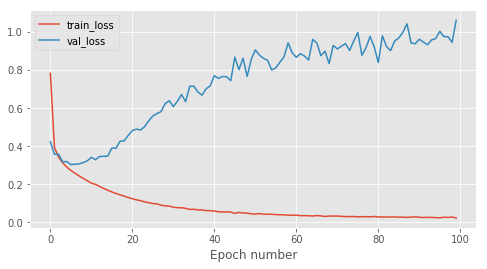

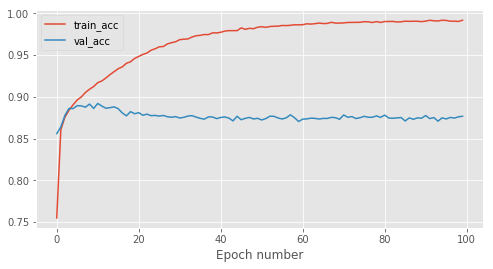

Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 15, 15])
torch.Size([100, 64, 15, 15])
torch.Size([100, 64, 8, 8])


loss: 3.8475, accuracy: 0.0100:   1%|          | 8/1000 [00:00<00:18, 52.63it/s]

torch.Size([100, 64, 8, 8])
torch.Size([100, 64, 5, 5])
torch.Size([100, 64, 5, 5])
torch.Size([100, 64, 3, 3])
torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU


loss: 0.4762, accuracy: 0.8400:   1%|          | 9/1000 [00:00<00:19, 51.72it/s]

Epoch 0: train_acc_0.7200_train_loss_0.9128_val_acc_0.8285_val_loss_0.4956 epoch time 21.3560 seconds


loss: 0.3832, accuracy: 0.8500:   1%|          | 10/1000 [00:00<00:18, 52.43it/s]

Epoch 1: train_acc_0.8443_train_loss_0.4509_val_acc_0.8577_val_loss_0.3947 epoch time 21.7782 seconds


loss: 0.2539, accuracy: 0.8900:   1%|          | 10/1000 [00:00<00:18, 52.16it/s]

Epoch 2: train_acc_0.8634_train_loss_0.3874_val_acc_0.8491_val_loss_0.4142 epoch time 21.7412 seconds


loss: 0.2802, accuracy: 0.9100:   1%|          | 10/1000 [00:00<00:18, 53.83it/s]

Epoch 3: train_acc_0.8736_train_loss_0.3542_val_acc_0.8709_val_loss_0.3716 epoch time 21.7260 seconds


loss: 0.3041, accuracy: 0.8800:   1%|          | 9/1000 [00:00<00:19, 51.76it/s]

Epoch 4: train_acc_0.8778_train_loss_0.3359_val_acc_0.8776_val_loss_0.3337 epoch time 21.7223 seconds


loss: 0.2169, accuracy: 0.9100:   1%|          | 10/1000 [00:00<00:18, 52.21it/s]

Epoch 5: train_acc_0.8858_train_loss_0.3132_val_acc_0.8789_val_loss_0.3276 epoch time 21.5169 seconds


loss: 0.2791, accuracy: 0.9300:   1%|          | 10/1000 [00:00<00:18, 52.36it/s]

Epoch 6: train_acc_0.8905_train_loss_0.2984_val_acc_0.8775_val_loss_0.3447 epoch time 21.7331 seconds


loss: 0.2409, accuracy: 0.9000:   1%|          | 10/1000 [00:00<00:18, 53.45it/s]

Epoch 7: train_acc_0.8929_train_loss_0.2852_val_acc_0.8851_val_loss_0.3251 epoch time 21.7945 seconds


loss: 0.1553, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:19, 51.54it/s]

Epoch 8: train_acc_0.8968_train_loss_0.2736_val_acc_0.8878_val_loss_0.3117 epoch time 21.7484 seconds


loss: 0.1531, accuracy: 0.9400:   1%|          | 10/1000 [00:00<00:18, 52.75it/s]

Epoch 9: train_acc_0.9002_train_loss_0.2621_val_acc_0.8882_val_loss_0.3149 epoch time 21.7937 seconds


loss: 0.2099, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:19, 50.48it/s]

Epoch 10: train_acc_0.9030_train_loss_0.2523_val_acc_0.8897_val_loss_0.3167 epoch time 21.7628 seconds


loss: 0.2090, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 53.81it/s]

Epoch 11: train_acc_0.9063_train_loss_0.2426_val_acc_0.8860_val_loss_0.3197 epoch time 21.7713 seconds


loss: 0.1460, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 51.47it/s]

Epoch 12: train_acc_0.9089_train_loss_0.2324_val_acc_0.8844_val_loss_0.3317 epoch time 21.7926 seconds


loss: 0.1823, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 52.54it/s]

Epoch 13: train_acc_0.9116_train_loss_0.2233_val_acc_0.8849_val_loss_0.3367 epoch time 21.8139 seconds


loss: 0.2883, accuracy: 0.8800:   1%|          | 10/1000 [00:00<00:18, 54.05it/s]

Epoch 14: train_acc_0.9147_train_loss_0.2146_val_acc_0.8901_val_loss_0.3260 epoch time 21.4952 seconds


loss: 0.2501, accuracy: 0.9100:   1%|          | 10/1000 [00:00<00:18, 52.58it/s]

Epoch 15: train_acc_0.9168_train_loss_0.2082_val_acc_0.8827_val_loss_0.3484 epoch time 21.6632 seconds


loss: 0.1610, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:19, 51.04it/s]

Epoch 16: train_acc_0.9193_train_loss_0.2003_val_acc_0.8846_val_loss_0.3534 epoch time 21.7301 seconds


loss: 0.1344, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:18, 52.37it/s]

Epoch 17: train_acc_0.9219_train_loss_0.1945_val_acc_0.8859_val_loss_0.3568 epoch time 21.7493 seconds


loss: 0.1615, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 50.72it/s]

Epoch 18: train_acc_0.9244_train_loss_0.1859_val_acc_0.8843_val_loss_0.3589 epoch time 21.7501 seconds


loss: 0.0930, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 52.05it/s]

Epoch 19: train_acc_0.9265_train_loss_0.1805_val_acc_0.8859_val_loss_0.3635 epoch time 21.6055 seconds


loss: 0.0599, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 51.11it/s]

Epoch 20: train_acc_0.9290_train_loss_0.1730_val_acc_0.8824_val_loss_0.3753 epoch time 21.7675 seconds


loss: 0.1556, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:18, 52.68it/s]

Epoch 21: train_acc_0.9314_train_loss_0.1666_val_acc_0.8812_val_loss_0.3897 epoch time 21.7730 seconds


loss: 0.1177, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:18, 52.24it/s]

Epoch 22: train_acc_0.9323_train_loss_0.1632_val_acc_0.8803_val_loss_0.3944 epoch time 21.7756 seconds


loss: 0.1570, accuracy: 0.9300:   1%|          | 10/1000 [00:00<00:18, 52.56it/s]

Epoch 23: train_acc_0.9356_train_loss_0.1557_val_acc_0.8784_val_loss_0.4162 epoch time 21.7652 seconds


loss: 0.1496, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 51.96it/s]

Epoch 24: train_acc_0.9363_train_loss_0.1523_val_acc_0.8799_val_loss_0.4086 epoch time 21.7706 seconds


loss: 0.1681, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:18, 52.75it/s]

Epoch 25: train_acc_0.9388_train_loss_0.1471_val_acc_0.8768_val_loss_0.4447 epoch time 21.7726 seconds


loss: 0.1048, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:18, 52.17it/s]

Epoch 26: train_acc_0.9407_train_loss_0.1424_val_acc_0.8767_val_loss_0.4458 epoch time 21.7346 seconds


loss: 0.1331, accuracy: 0.9600:   1%|          | 10/1000 [00:00<00:18, 53.05it/s]

Epoch 27: train_acc_0.9417_train_loss_0.1384_val_acc_0.8765_val_loss_0.4736 epoch time 21.7838 seconds


loss: 0.1220, accuracy: 0.9600:   1%|          | 10/1000 [00:00<00:18, 52.62it/s]

Epoch 28: train_acc_0.9446_train_loss_0.1332_val_acc_0.8744_val_loss_0.4764 epoch time 21.7362 seconds


loss: 0.1105, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:19, 50.95it/s]

Epoch 29: train_acc_0.9444_train_loss_0.1325_val_acc_0.8764_val_loss_0.4933 epoch time 21.4740 seconds


loss: 0.1277, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 50.71it/s]

Epoch 30: train_acc_0.9466_train_loss_0.1268_val_acc_0.8787_val_loss_0.4825 epoch time 21.7492 seconds


loss: 0.1343, accuracy: 0.9300:   1%|          | 10/1000 [00:00<00:18, 52.18it/s]

Epoch 31: train_acc_0.9481_train_loss_0.1239_val_acc_0.8770_val_loss_0.5203 epoch time 21.7303 seconds


loss: 0.1793, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 51.61it/s]

Epoch 32: train_acc_0.9494_train_loss_0.1203_val_acc_0.8802_val_loss_0.5129 epoch time 21.7144 seconds


loss: 0.1151, accuracy: 0.9300:   1%|          | 10/1000 [00:00<00:18, 52.43it/s]

Epoch 33: train_acc_0.9501_train_loss_0.1184_val_acc_0.8765_val_loss_0.5234 epoch time 21.5165 seconds


loss: 0.1190, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 49.83it/s]

Epoch 34: train_acc_0.9519_train_loss_0.1146_val_acc_0.8732_val_loss_0.5327 epoch time 21.8008 seconds


loss: 0.0822, accuracy: 0.9800:   1%|          | 10/1000 [00:00<00:18, 53.54it/s]

Epoch 35: train_acc_0.9516_train_loss_0.1136_val_acc_0.8780_val_loss_0.5509 epoch time 21.7669 seconds


loss: 0.0859, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 50.63it/s]

Epoch 36: train_acc_0.9545_train_loss_0.1093_val_acc_0.8766_val_loss_0.5695 epoch time 21.6389 seconds


loss: 0.0634, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:19, 52.00it/s]

Epoch 37: train_acc_0.9551_train_loss_0.1079_val_acc_0.8753_val_loss_0.5739 epoch time 21.7544 seconds


loss: 0.0425, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:19, 50.60it/s]

Epoch 38: train_acc_0.9558_train_loss_0.1063_val_acc_0.8772_val_loss_0.5552 epoch time 21.7159 seconds


loss: 0.0988, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 50.97it/s]

Epoch 39: train_acc_0.9565_train_loss_0.1024_val_acc_0.8718_val_loss_0.5755 epoch time 21.8707 seconds


loss: 0.0817, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:18, 52.63it/s]

Epoch 40: train_acc_0.9575_train_loss_0.1015_val_acc_0.8756_val_loss_0.6212 epoch time 21.6833 seconds


loss: 0.0803, accuracy: 0.9600:   1%|          | 10/1000 [00:00<00:18, 53.02it/s]

Epoch 41: train_acc_0.9587_train_loss_0.1005_val_acc_0.8760_val_loss_0.5892 epoch time 21.5670 seconds


loss: 0.0510, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:18, 52.47it/s]

Epoch 42: train_acc_0.9611_train_loss_0.0946_val_acc_0.8739_val_loss_0.6168 epoch time 21.5719 seconds


loss: 0.1052, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:18, 54.26it/s]

Epoch 43: train_acc_0.9598_train_loss_0.0966_val_acc_0.8746_val_loss_0.6298 epoch time 21.3417 seconds


loss: 0.0763, accuracy: 0.9600:   1%|          | 10/1000 [00:00<00:19, 50.95it/s]

Epoch 44: train_acc_0.9616_train_loss_0.0923_val_acc_0.8720_val_loss_0.6346 epoch time 21.7063 seconds


loss: 0.0934, accuracy: 0.9600:   1%|          | 10/1000 [00:00<00:18, 52.99it/s]

Epoch 45: train_acc_0.9622_train_loss_0.0900_val_acc_0.8759_val_loss_0.6343 epoch time 21.7799 seconds


loss: 0.0458, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:19, 50.68it/s]

Epoch 46: train_acc_0.9621_train_loss_0.0906_val_acc_0.8756_val_loss_0.6460 epoch time 21.7007 seconds


loss: 0.0495, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:18, 53.70it/s]

Epoch 47: train_acc_0.9637_train_loss_0.0880_val_acc_0.8759_val_loss_0.6515 epoch time 21.5062 seconds


loss: 0.0272, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:18, 52.24it/s]

Epoch 48: train_acc_0.9640_train_loss_0.0866_val_acc_0.8709_val_loss_0.6667 epoch time 21.7227 seconds


loss: 0.0549, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:18, 52.32it/s]

Epoch 49: train_acc_0.9649_train_loss_0.0862_val_acc_0.8701_val_loss_0.7174 epoch time 21.7184 seconds


loss: 0.0933, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 50.87it/s]

Epoch 50: train_acc_0.9651_train_loss_0.0844_val_acc_0.8713_val_loss_0.6872 epoch time 21.7099 seconds


loss: 0.1077, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 54.51it/s]

Epoch 51: train_acc_0.9656_train_loss_0.0829_val_acc_0.8733_val_loss_0.6875 epoch time 21.7853 seconds


loss: 0.0693, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 50.37it/s]

Epoch 52: train_acc_0.9687_train_loss_0.0779_val_acc_0.8714_val_loss_0.7231 epoch time 21.7158 seconds


loss: 0.0475, accuracy: 0.9800:   1%|          | 10/1000 [00:00<00:18, 52.39it/s]

Epoch 53: train_acc_0.9654_train_loss_0.0842_val_acc_0.8763_val_loss_0.7239 epoch time 21.7678 seconds


loss: 0.0874, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 50.63it/s]

Epoch 54: train_acc_0.9678_train_loss_0.0781_val_acc_0.8725_val_loss_0.7106 epoch time 21.6630 seconds


loss: 0.0275, accuracy: 1.0000:   1%|          | 9/1000 [00:00<00:19, 52.03it/s]

Epoch 55: train_acc_0.9688_train_loss_0.0783_val_acc_0.8709_val_loss_0.7363 epoch time 21.7343 seconds


loss: 0.0235, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:19, 50.34it/s]

Epoch 56: train_acc_0.9682_train_loss_0.0791_val_acc_0.8726_val_loss_0.7104 epoch time 21.7560 seconds


loss: 0.1093, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:17, 55.28it/s]

Epoch 57: train_acc_0.9688_train_loss_0.0753_val_acc_0.8682_val_loss_0.7414 epoch time 21.5145 seconds


loss: 0.1186, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:18, 52.75it/s]

Epoch 58: train_acc_0.9698_train_loss_0.0738_val_acc_0.8724_val_loss_0.7480 epoch time 21.6884 seconds


loss: 0.0628, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 51.93it/s]

Epoch 59: train_acc_0.9693_train_loss_0.0750_val_acc_0.8715_val_loss_0.7545 epoch time 21.7437 seconds


loss: 0.1056, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 51.04it/s]

Epoch 60: train_acc_0.9712_train_loss_0.0705_val_acc_0.8687_val_loss_0.7870 epoch time 21.7452 seconds


loss: 0.1197, accuracy: 0.9600:   1%|          | 10/1000 [00:00<00:18, 53.27it/s]

Epoch 61: train_acc_0.9711_train_loss_0.0722_val_acc_0.8697_val_loss_0.7664 epoch time 21.5963 seconds


loss: 0.0806, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 50.55it/s]

Epoch 62: train_acc_0.9729_train_loss_0.0678_val_acc_0.8723_val_loss_0.7783 epoch time 21.7260 seconds


loss: 0.0728, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:18, 52.28it/s]

Epoch 63: train_acc_0.9708_train_loss_0.0717_val_acc_0.8734_val_loss_0.7814 epoch time 21.7686 seconds


loss: 0.0563, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 51.07it/s]

Epoch 64: train_acc_0.9737_train_loss_0.0655_val_acc_0.8739_val_loss_0.8075 epoch time 21.7181 seconds


loss: 0.0758, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:18, 53.02it/s]

Epoch 65: train_acc_0.9727_train_loss_0.0668_val_acc_0.8742_val_loss_0.7949 epoch time 21.7186 seconds


loss: 0.0765, accuracy: 0.9800:   1%|          | 10/1000 [00:00<00:19, 52.05it/s]

Epoch 66: train_acc_0.9744_train_loss_0.0641_val_acc_0.8703_val_loss_0.8295 epoch time 21.7102 seconds


loss: 0.1058, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 52.63it/s]

Epoch 67: train_acc_0.9731_train_loss_0.0679_val_acc_0.8663_val_loss_0.8231 epoch time 21.7372 seconds


loss: 0.0827, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:18, 52.44it/s]

Epoch 68: train_acc_0.9748_train_loss_0.0639_val_acc_0.8724_val_loss_0.8243 epoch time 21.7089 seconds


loss: 0.0923, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:18, 53.32it/s]

Epoch 69: train_acc_0.9749_train_loss_0.0629_val_acc_0.8716_val_loss_0.8192 epoch time 21.7320 seconds


loss: 0.0565, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:19, 51.19it/s]

Epoch 70: train_acc_0.9742_train_loss_0.0646_val_acc_0.8700_val_loss_0.8315 epoch time 21.7037 seconds


loss: 0.0479, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:18, 54.87it/s]

Epoch 71: train_acc_0.9755_train_loss_0.0612_val_acc_0.8715_val_loss_0.8015 epoch time 21.6883 seconds


loss: 0.0682, accuracy: 0.9600:   1%|          | 10/1000 [00:00<00:19, 51.97it/s]

Epoch 72: train_acc_0.9764_train_loss_0.0591_val_acc_0.8690_val_loss_0.8905 epoch time 21.3988 seconds


loss: 0.0324, accuracy: 0.9900:   1%|          | 10/1000 [00:00<00:18, 53.24it/s]

Epoch 73: train_acc_0.9754_train_loss_0.0622_val_acc_0.8697_val_loss_0.8393 epoch time 21.7528 seconds


loss: 0.0623, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 51.68it/s]

Epoch 74: train_acc_0.9771_train_loss_0.0588_val_acc_0.8735_val_loss_0.8248 epoch time 21.6937 seconds


loss: 0.0722, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:18, 52.77it/s]

Epoch 75: train_acc_0.9764_train_loss_0.0594_val_acc_0.8739_val_loss_0.8532 epoch time 21.5847 seconds


loss: 0.0190, accuracy: 1.0000:   1%|          | 9/1000 [00:00<00:19, 51.50it/s]

Epoch 76: train_acc_0.9775_train_loss_0.0585_val_acc_0.8735_val_loss_0.8489 epoch time 21.6950 seconds


loss: 0.1472, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:18, 53.78it/s]

Epoch 77: train_acc_0.9779_train_loss_0.0557_val_acc_0.8719_val_loss_0.8830 epoch time 21.7658 seconds


loss: 0.0331, accuracy: 0.9800:   1%|          | 10/1000 [00:00<00:19, 51.22it/s]

Epoch 78: train_acc_0.9785_train_loss_0.0553_val_acc_0.8737_val_loss_0.8750 epoch time 21.7148 seconds


loss: 0.0098, accuracy: 1.0000:   1%|          | 9/1000 [00:00<00:18, 52.31it/s]

Epoch 79: train_acc_0.9780_train_loss_0.0555_val_acc_0.8693_val_loss_0.8984 epoch time 21.6758 seconds


loss: 0.0525, accuracy: 0.9900:   1%|          | 10/1000 [00:00<00:18, 52.49it/s]

Epoch 80: train_acc_0.9783_train_loss_0.0554_val_acc_0.8708_val_loss_0.8678 epoch time 21.7423 seconds


loss: 0.0475, accuracy: 0.9800:   1%|          | 10/1000 [00:00<00:18, 52.59it/s]

Epoch 81: train_acc_0.9800_train_loss_0.0514_val_acc_0.8715_val_loss_0.9245 epoch time 21.7860 seconds


loss: 0.0524, accuracy: 0.9900:   1%|          | 10/1000 [00:00<00:18, 53.14it/s]

Epoch 82: train_acc_0.9781_train_loss_0.0584_val_acc_0.8689_val_loss_0.9308 epoch time 21.7227 seconds


loss: 0.0297, accuracy: 0.9900:   1%|          | 10/1000 [00:00<00:18, 52.12it/s]

Epoch 83: train_acc_0.9792_train_loss_0.0527_val_acc_0.8700_val_loss_0.9142 epoch time 21.7460 seconds


loss: 0.0362, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 51.11it/s]

Epoch 84: train_acc_0.9798_train_loss_0.0513_val_acc_0.8701_val_loss_0.9128 epoch time 21.7604 seconds


loss: 0.0258, accuracy: 0.9900:   1%|          | 10/1000 [00:00<00:18, 53.47it/s]

Epoch 85: train_acc_0.9810_train_loss_0.0494_val_acc_0.8670_val_loss_0.9485 epoch time 21.7697 seconds


loss: 0.0574, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 51.03it/s]

Epoch 86: train_acc_0.9798_train_loss_0.0516_val_acc_0.8711_val_loss_0.9447 epoch time 21.2798 seconds


loss: 0.0430, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:18, 52.18it/s]

Epoch 87: train_acc_0.9801_train_loss_0.0516_val_acc_0.8684_val_loss_0.9773 epoch time 21.7575 seconds


loss: 0.0876, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:18, 52.18it/s]

Epoch 88: train_acc_0.9813_train_loss_0.0485_val_acc_0.8728_val_loss_0.9399 epoch time 21.6982 seconds


loss: 0.0429, accuracy: 0.9800:   1%|          | 10/1000 [00:00<00:18, 52.57it/s]

Epoch 89: train_acc_0.9801_train_loss_0.0514_val_acc_0.8678_val_loss_0.9396 epoch time 21.5215 seconds


loss: 0.0518, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 50.33it/s]

Epoch 90: train_acc_0.9811_train_loss_0.0497_val_acc_0.8720_val_loss_0.9237 epoch time 21.7282 seconds


loss: 0.0695, accuracy: 0.9800:   1%|          | 10/1000 [00:00<00:19, 51.91it/s]

Epoch 91: train_acc_0.9818_train_loss_0.0475_val_acc_0.8672_val_loss_0.9488 epoch time 21.7646 seconds


loss: 0.0648, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:18, 52.27it/s]

Epoch 92: train_acc_0.9812_train_loss_0.0514_val_acc_0.8733_val_loss_0.9851 epoch time 21.7022 seconds


loss: 0.0418, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:18, 52.64it/s]

Epoch 93: train_acc_0.9829_train_loss_0.0449_val_acc_0.8674_val_loss_0.9736 epoch time 21.7276 seconds


loss: 0.0189, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:19, 51.98it/s]

Epoch 94: train_acc_0.9824_train_loss_0.0462_val_acc_0.8669_val_loss_0.9736 epoch time 21.7085 seconds


loss: 0.0368, accuracy: 0.9800:   1%|          | 10/1000 [00:00<00:18, 53.33it/s]

Epoch 95: train_acc_0.9816_train_loss_0.0480_val_acc_0.8713_val_loss_0.9908 epoch time 21.7326 seconds


loss: 0.0523, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:19, 50.56it/s]

Epoch 96: train_acc_0.9813_train_loss_0.0488_val_acc_0.8668_val_loss_0.9963 epoch time 21.6834 seconds


loss: 0.0268, accuracy: 0.9900:   1%|          | 10/1000 [00:00<00:18, 52.59it/s]

Epoch 97: train_acc_0.9837_train_loss_0.0429_val_acc_0.8692_val_loss_0.9694 epoch time 21.7598 seconds


loss: 0.0508, accuracy: 0.9900:   1%|          | 10/1000 [00:00<00:18, 52.61it/s]

Epoch 98: train_acc_0.9834_train_loss_0.0441_val_acc_0.8698_val_loss_0.9847 epoch time 21.6799 seconds


loss: 0.3603, accuracy: 0.8300:  13%|█▎        | 21/158 [00:00<00:01, 115.52it/s]

Epoch 99: train_acc_0.9832_train_loss_0.0441_val_acc_0.8688_val_loss_1.0365 epoch time 21.7378 seconds
Generating test set evaluation metrics


loss: 0.4000, accuracy: 0.8900: 100%|██████████| 158/158 [00:01<00:00, 100.17it/s]


finish


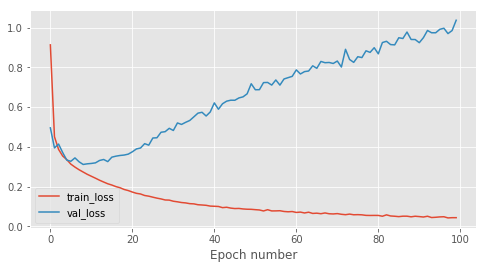

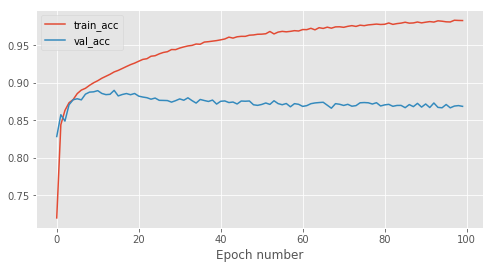

Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 15, 15])
torch.Size([100, 64, 15, 15])
torch.Size([100, 64, 8, 8])
torch.Size([100, 64, 8, 8])
torch.Size([100, 64, 5, 5])


loss: 3.8516, accuracy: 0.0300:   1%|          | 8/1000 [00:00<00:20, 48.16it/s]

torch.Size([100, 64, 5, 5])
torch.Size([100, 64, 3, 3])
torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU


loss: 0.5322, accuracy: 0.8000:   1%|          | 9/1000 [00:00<00:19, 49.83it/s]

Epoch 0: train_acc_0.6173_train_loss_1.2992_val_acc_0.7618_val_loss_0.7122 epoch time 21.6813 seconds


loss: 0.6495, accuracy: 0.7600:   1%|          | 9/1000 [00:00<00:19, 51.58it/s]

Epoch 1: train_acc_0.8001_train_loss_0.6046_val_acc_0.8280_val_loss_0.5125 epoch time 22.1473 seconds


loss: 0.4992, accuracy: 0.8200:   1%|          | 9/1000 [00:00<00:19, 50.69it/s]

Epoch 2: train_acc_0.8279_train_loss_0.5085_val_acc_0.8464_val_loss_0.4532 epoch time 22.1331 seconds


loss: 0.4404, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:18, 52.24it/s]

Epoch 3: train_acc_0.8449_train_loss_0.4555_val_acc_0.8496_val_loss_0.4336 epoch time 21.9412 seconds


loss: 0.3336, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:19, 49.92it/s]

Epoch 4: train_acc_0.8520_train_loss_0.4232_val_acc_0.8520_val_loss_0.4147 epoch time 22.1145 seconds


loss: 0.4264, accuracy: 0.8400:   1%|          | 9/1000 [00:00<00:19, 50.69it/s]

Epoch 5: train_acc_0.8585_train_loss_0.4007_val_acc_0.8597_val_loss_0.3924 epoch time 22.1596 seconds


loss: 0.3544, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 50.94it/s]

Epoch 6: train_acc_0.8665_train_loss_0.3790_val_acc_0.8688_val_loss_0.3721 epoch time 22.1056 seconds


loss: 0.2679, accuracy: 0.8800:   1%|          | 9/1000 [00:00<00:19, 52.02it/s]

Epoch 7: train_acc_0.8692_train_loss_0.3656_val_acc_0.8697_val_loss_0.3615 epoch time 22.1691 seconds


loss: 0.2915, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:19, 50.41it/s]

Epoch 8: train_acc_0.8751_train_loss_0.3496_val_acc_0.8788_val_loss_0.3416 epoch time 22.0408 seconds


loss: 0.3414, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:19, 51.05it/s]

Epoch 9: train_acc_0.8773_train_loss_0.3391_val_acc_0.8756_val_loss_0.3408 epoch time 22.0983 seconds


loss: 0.2785, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:19, 50.27it/s]

Epoch 10: train_acc_0.8807_train_loss_0.3279_val_acc_0.8753_val_loss_0.3466 epoch time 22.1892 seconds


loss: 0.2645, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 51.84it/s]

Epoch 11: train_acc_0.8827_train_loss_0.3194_val_acc_0.8799_val_loss_0.3431 epoch time 22.1506 seconds


loss: 0.2170, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:19, 50.03it/s]

Epoch 12: train_acc_0.8863_train_loss_0.3112_val_acc_0.8811_val_loss_0.3347 epoch time 22.1064 seconds


loss: 0.2627, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:19, 51.17it/s]

Epoch 13: train_acc_0.8879_train_loss_0.3035_val_acc_0.8710_val_loss_0.3471 epoch time 22.1546 seconds


loss: 0.3709, accuracy: 0.8600:   1%|          | 9/1000 [00:00<00:20, 48.19it/s]

Epoch 14: train_acc_0.8901_train_loss_0.2952_val_acc_0.8825_val_loss_0.3286 epoch time 21.7018 seconds


loss: 0.3415, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:19, 50.95it/s]

Epoch 15: train_acc_0.8927_train_loss_0.2880_val_acc_0.8817_val_loss_0.3300 epoch time 22.2053 seconds


loss: 0.1616, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 49.70it/s]

Epoch 16: train_acc_0.8954_train_loss_0.2804_val_acc_0.8835_val_loss_0.3285 epoch time 22.2312 seconds


loss: 0.2244, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:19, 51.83it/s]

Epoch 17: train_acc_0.8959_train_loss_0.2759_val_acc_0.8830_val_loss_0.3258 epoch time 21.9958 seconds


loss: 0.3591, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:19, 49.64it/s]

Epoch 18: train_acc_0.8977_train_loss_0.2697_val_acc_0.8839_val_loss_0.3191 epoch time 22.1196 seconds


loss: 0.3103, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:19, 51.45it/s]

Epoch 19: train_acc_0.9001_train_loss_0.2634_val_acc_0.8822_val_loss_0.3278 epoch time 22.2049 seconds


loss: 0.2231, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:19, 50.72it/s]

Epoch 20: train_acc_0.9013_train_loss_0.2579_val_acc_0.8777_val_loss_0.3308 epoch time 22.1447 seconds


loss: 0.1932, accuracy: 0.9100:   1%|          | 10/1000 [00:00<00:18, 53.17it/s]

Epoch 21: train_acc_0.9033_train_loss_0.2531_val_acc_0.8858_val_loss_0.3398 epoch time 22.1487 seconds


loss: 0.2712, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:19, 50.65it/s]

Epoch 22: train_acc_0.9029_train_loss_0.2505_val_acc_0.8866_val_loss_0.3221 epoch time 22.1407 seconds


loss: 0.2737, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:19, 51.28it/s]

Epoch 23: train_acc_0.9059_train_loss_0.2444_val_acc_0.8813_val_loss_0.3315 epoch time 22.1632 seconds


loss: 0.1977, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 50.30it/s]

Epoch 24: train_acc_0.9068_train_loss_0.2391_val_acc_0.8844_val_loss_0.3288 epoch time 22.1792 seconds


loss: 0.4071, accuracy: 0.8600:   1%|          | 10/1000 [00:00<00:18, 52.68it/s]

Epoch 25: train_acc_0.9092_train_loss_0.2348_val_acc_0.8876_val_loss_0.3246 epoch time 22.2029 seconds


loss: 0.2695, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:19, 50.93it/s]

Epoch 26: train_acc_0.9103_train_loss_0.2295_val_acc_0.8859_val_loss_0.3309 epoch time 22.1190 seconds


loss: 0.1997, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 51.93it/s]

Epoch 27: train_acc_0.9106_train_loss_0.2271_val_acc_0.8850_val_loss_0.3369 epoch time 22.1504 seconds


loss: 0.2490, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:19, 49.96it/s]

Epoch 28: train_acc_0.9123_train_loss_0.2234_val_acc_0.8845_val_loss_0.3349 epoch time 21.7674 seconds


loss: 0.2771, accuracy: 0.8700:   1%|          | 9/1000 [00:00<00:19, 51.34it/s]

Epoch 29: train_acc_0.9131_train_loss_0.2190_val_acc_0.8899_val_loss_0.3274 epoch time 22.1860 seconds


loss: 0.2118, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:19, 51.67it/s]

Epoch 30: train_acc_0.9149_train_loss_0.2155_val_acc_0.8853_val_loss_0.3352 epoch time 22.1011 seconds


loss: 0.1699, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:19, 51.94it/s]

Epoch 31: train_acc_0.9157_train_loss_0.2116_val_acc_0.8816_val_loss_0.3526 epoch time 21.9847 seconds


loss: 0.2003, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:19, 52.01it/s]

Epoch 32: train_acc_0.9173_train_loss_0.2077_val_acc_0.8818_val_loss_0.3394 epoch time 22.1163 seconds


loss: 0.2011, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:19, 51.72it/s]

Epoch 33: train_acc_0.9188_train_loss_0.2039_val_acc_0.8799_val_loss_0.3517 epoch time 22.1122 seconds


loss: 0.2021, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:19, 49.66it/s]

Epoch 34: train_acc_0.9181_train_loss_0.2022_val_acc_0.8861_val_loss_0.3459 epoch time 22.1328 seconds


loss: 0.2294, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:19, 51.78it/s]

Epoch 35: train_acc_0.9204_train_loss_0.1971_val_acc_0.8824_val_loss_0.3584 epoch time 22.0321 seconds


loss: 0.2060, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:19, 51.10it/s]

Epoch 36: train_acc_0.9220_train_loss_0.1933_val_acc_0.8792_val_loss_0.3634 epoch time 22.0904 seconds


loss: 0.1310, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:19, 51.88it/s]

Epoch 37: train_acc_0.9224_train_loss_0.1912_val_acc_0.8801_val_loss_0.3643 epoch time 22.0929 seconds


loss: 0.2395, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 50.20it/s]

Epoch 38: train_acc_0.9230_train_loss_0.1886_val_acc_0.8787_val_loss_0.3848 epoch time 22.0803 seconds


loss: 0.1890, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 51.80it/s]

Epoch 39: train_acc_0.9252_train_loss_0.1851_val_acc_0.8784_val_loss_0.3840 epoch time 22.0723 seconds


loss: 0.1889, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:19, 50.65it/s]

Epoch 40: train_acc_0.9249_train_loss_0.1829_val_acc_0.8773_val_loss_0.3707 epoch time 22.0916 seconds


loss: 0.2097, accuracy: 0.8900:   1%|          | 10/1000 [00:00<00:19, 51.95it/s]

Epoch 41: train_acc_0.9261_train_loss_0.1807_val_acc_0.8773_val_loss_0.3778 epoch time 22.0023 seconds


loss: 0.0823, accuracy: 0.9800:   1%|          | 10/1000 [00:00<00:18, 52.69it/s]

Epoch 42: train_acc_0.9270_train_loss_0.1780_val_acc_0.8790_val_loss_0.3825 epoch time 21.6721 seconds


loss: 0.1384, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 51.78it/s]

Epoch 43: train_acc_0.9274_train_loss_0.1750_val_acc_0.8829_val_loss_0.3791 epoch time 22.0758 seconds


loss: 0.1307, accuracy: 0.9300:   1%|          | 10/1000 [00:00<00:19, 52.02it/s]

Epoch 44: train_acc_0.9291_train_loss_0.1711_val_acc_0.8788_val_loss_0.3913 epoch time 21.9502 seconds


loss: 0.2252, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:19, 50.80it/s]

Epoch 45: train_acc_0.9296_train_loss_0.1703_val_acc_0.8792_val_loss_0.3944 epoch time 21.9026 seconds


loss: 0.1395, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:18, 52.59it/s]

Epoch 46: train_acc_0.9299_train_loss_0.1676_val_acc_0.8795_val_loss_0.3915 epoch time 21.9840 seconds


loss: 0.2043, accuracy: 0.9100:   1%|          | 10/1000 [00:00<00:18, 52.16it/s]

Epoch 47: train_acc_0.9327_train_loss_0.1637_val_acc_0.8755_val_loss_0.4213 epoch time 22.0474 seconds


loss: 0.1916, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:19, 49.65it/s]

Epoch 48: train_acc_0.9325_train_loss_0.1623_val_acc_0.8732_val_loss_0.4162 epoch time 22.1149 seconds


loss: 0.1794, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:19, 51.64it/s]

Epoch 49: train_acc_0.9327_train_loss_0.1599_val_acc_0.8730_val_loss_0.4368 epoch time 22.0767 seconds


loss: 0.1261, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 51.32it/s]

Epoch 50: train_acc_0.9335_train_loss_0.1585_val_acc_0.8741_val_loss_0.4177 epoch time 22.0723 seconds


loss: 0.1276, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 51.36it/s]

Epoch 51: train_acc_0.9345_train_loss_0.1572_val_acc_0.8782_val_loss_0.4256 epoch time 22.1554 seconds


loss: 0.1255, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:19, 49.78it/s]

Epoch 52: train_acc_0.9352_train_loss_0.1535_val_acc_0.8764_val_loss_0.4306 epoch time 22.0882 seconds


loss: 0.1257, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:18, 53.22it/s]

Epoch 53: train_acc_0.9367_train_loss_0.1510_val_acc_0.8778_val_loss_0.4310 epoch time 22.1531 seconds


loss: 0.1218, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 50.95it/s]

Epoch 54: train_acc_0.9370_train_loss_0.1509_val_acc_0.8758_val_loss_0.4419 epoch time 22.0711 seconds


loss: 0.2335, accuracy: 0.8700:   1%|          | 10/1000 [00:00<00:19, 51.79it/s]

Epoch 55: train_acc_0.9379_train_loss_0.1470_val_acc_0.8777_val_loss_0.4564 epoch time 22.1145 seconds


loss: 0.0753, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:18, 52.22it/s]

Epoch 56: train_acc_0.9389_train_loss_0.1460_val_acc_0.8753_val_loss_0.4437 epoch time 21.8693 seconds


loss: 0.1253, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 51.13it/s]

Epoch 57: train_acc_0.9388_train_loss_0.1446_val_acc_0.8738_val_loss_0.4542 epoch time 22.0984 seconds


loss: 0.1162, accuracy: 0.9600:   1%|          | 10/1000 [00:00<00:19, 51.45it/s]

Epoch 58: train_acc_0.9396_train_loss_0.1425_val_acc_0.8746_val_loss_0.4646 epoch time 22.0375 seconds


loss: 0.1479, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 51.33it/s]

Epoch 59: train_acc_0.9405_train_loss_0.1396_val_acc_0.8754_val_loss_0.4558 epoch time 22.0441 seconds


loss: 0.1573, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 49.58it/s]

Epoch 60: train_acc_0.9413_train_loss_0.1389_val_acc_0.8755_val_loss_0.4898 epoch time 22.1177 seconds


loss: 0.0985, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 52.12it/s]

Epoch 61: train_acc_0.9423_train_loss_0.1379_val_acc_0.8767_val_loss_0.4905 epoch time 22.1289 seconds


loss: 0.0510, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 49.55it/s]

Epoch 62: train_acc_0.9425_train_loss_0.1359_val_acc_0.8780_val_loss_0.4866 epoch time 22.1087 seconds


loss: 0.1103, accuracy: 0.9600:   1%|          | 10/1000 [00:00<00:19, 51.38it/s]

Epoch 63: train_acc_0.9429_train_loss_0.1341_val_acc_0.8757_val_loss_0.5056 epoch time 22.1778 seconds


loss: 0.1378, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 51.18it/s]

Epoch 64: train_acc_0.9443_train_loss_0.1315_val_acc_0.8741_val_loss_0.5109 epoch time 22.0913 seconds


loss: 0.2218, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:19, 51.12it/s]

Epoch 65: train_acc_0.9453_train_loss_0.1299_val_acc_0.8748_val_loss_0.4847 epoch time 22.1667 seconds


loss: 0.1961, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 50.85it/s]

Epoch 66: train_acc_0.9449_train_loss_0.1298_val_acc_0.8718_val_loss_0.4950 epoch time 22.0568 seconds


loss: 0.0872, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 51.44it/s]

Epoch 67: train_acc_0.9461_train_loss_0.1266_val_acc_0.8707_val_loss_0.5066 epoch time 22.1580 seconds


loss: 0.0808, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 51.25it/s]

Epoch 68: train_acc_0.9464_train_loss_0.1261_val_acc_0.8730_val_loss_0.5251 epoch time 22.1453 seconds


loss: 0.0714, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:19, 52.01it/s]

Epoch 69: train_acc_0.9468_train_loss_0.1264_val_acc_0.8715_val_loss_0.5069 epoch time 22.1048 seconds


loss: 0.1427, accuracy: 0.9400:   1%|          | 10/1000 [00:00<00:18, 52.22it/s]

Epoch 70: train_acc_0.9474_train_loss_0.1237_val_acc_0.8740_val_loss_0.5170 epoch time 21.8430 seconds


loss: 0.0627, accuracy: 0.9900:   1%|          | 10/1000 [00:00<00:18, 52.61it/s]

Epoch 71: train_acc_0.9496_train_loss_0.1193_val_acc_0.8717_val_loss_0.5262 epoch time 22.0143 seconds


loss: 0.1191, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 50.93it/s]

Epoch 72: train_acc_0.9484_train_loss_0.1218_val_acc_0.8766_val_loss_0.5128 epoch time 21.9087 seconds


loss: 0.1288, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 51.31it/s]

Epoch 73: train_acc_0.9496_train_loss_0.1189_val_acc_0.8702_val_loss_0.5400 epoch time 22.1266 seconds


loss: 0.1009, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 50.56it/s]

Epoch 74: train_acc_0.9504_train_loss_0.1179_val_acc_0.8708_val_loss_0.5402 epoch time 22.1411 seconds


loss: 0.1572, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 51.69it/s]

Epoch 75: train_acc_0.9503_train_loss_0.1170_val_acc_0.8732_val_loss_0.5330 epoch time 22.0833 seconds


loss: 0.0746, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 49.59it/s]

Epoch 76: train_acc_0.9504_train_loss_0.1167_val_acc_0.8751_val_loss_0.5370 epoch time 22.1453 seconds


loss: 0.0665, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 50.89it/s]

Epoch 77: train_acc_0.9515_train_loss_0.1143_val_acc_0.8744_val_loss_0.5386 epoch time 22.1352 seconds


loss: 0.1458, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 50.40it/s]

Epoch 78: train_acc_0.9505_train_loss_0.1154_val_acc_0.8764_val_loss_0.5621 epoch time 22.1590 seconds


loss: 0.1213, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 54.17it/s]

Epoch 79: train_acc_0.9533_train_loss_0.1100_val_acc_0.8713_val_loss_0.5617 epoch time 22.1017 seconds


loss: 0.0613, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 51.74it/s]

Epoch 80: train_acc_0.9527_train_loss_0.1108_val_acc_0.8728_val_loss_0.5579 epoch time 22.0967 seconds


loss: 0.0939, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 50.95it/s]

Epoch 81: train_acc_0.9542_train_loss_0.1101_val_acc_0.8726_val_loss_0.5527 epoch time 22.1870 seconds


loss: 0.1131, accuracy: 0.9600:   1%|          | 10/1000 [00:00<00:18, 52.17it/s]

Epoch 82: train_acc_0.9542_train_loss_0.1099_val_acc_0.8697_val_loss_0.5789 epoch time 22.1659 seconds


loss: 0.0311, accuracy: 1.0000:   1%|          | 9/1000 [00:00<00:19, 50.97it/s]

Epoch 83: train_acc_0.9541_train_loss_0.1090_val_acc_0.8701_val_loss_0.5793 epoch time 22.0858 seconds


loss: 0.0915, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:19, 51.58it/s]

Epoch 84: train_acc_0.9542_train_loss_0.1076_val_acc_0.8708_val_loss_0.5857 epoch time 21.9534 seconds


loss: 0.0473, accuracy: 0.9900:   1%|          | 10/1000 [00:00<00:18, 52.91it/s]

Epoch 85: train_acc_0.9551_train_loss_0.1060_val_acc_0.8764_val_loss_0.5866 epoch time 22.0121 seconds


loss: 0.0781, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 49.24it/s]

Epoch 86: train_acc_0.9547_train_loss_0.1071_val_acc_0.8687_val_loss_0.5919 epoch time 21.9744 seconds


loss: 0.1454, accuracy: 0.9300:   1%|          | 10/1000 [00:00<00:18, 52.45it/s]

Epoch 87: train_acc_0.9564_train_loss_0.1032_val_acc_0.8729_val_loss_0.5864 epoch time 22.1559 seconds


loss: 0.1168, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 50.75it/s]

Epoch 88: train_acc_0.9562_train_loss_0.1051_val_acc_0.8687_val_loss_0.5940 epoch time 22.1004 seconds


loss: 0.0968, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 51.23it/s]

Epoch 89: train_acc_0.9571_train_loss_0.1017_val_acc_0.8658_val_loss_0.6114 epoch time 22.1129 seconds


loss: 0.1412, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 51.33it/s]

Epoch 90: train_acc_0.9570_train_loss_0.1022_val_acc_0.8716_val_loss_0.6103 epoch time 22.1189 seconds


loss: 0.0990, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 51.96it/s]

Epoch 91: train_acc_0.9570_train_loss_0.1010_val_acc_0.8711_val_loss_0.6062 epoch time 22.1113 seconds


loss: 0.0715, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:19, 50.40it/s]

Epoch 92: train_acc_0.9573_train_loss_0.1015_val_acc_0.8732_val_loss_0.6168 epoch time 22.1087 seconds


loss: 0.2082, accuracy: 0.9300:   1%|          | 10/1000 [00:00<00:18, 52.29it/s]

Epoch 93: train_acc_0.9580_train_loss_0.0995_val_acc_0.8706_val_loss_0.6234 epoch time 22.1540 seconds


loss: 0.1121, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 50.36it/s]

Epoch 94: train_acc_0.9581_train_loss_0.0972_val_acc_0.8733_val_loss_0.6412 epoch time 22.0314 seconds


loss: 0.0736, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 51.33it/s]

Epoch 95: train_acc_0.9588_train_loss_0.0982_val_acc_0.8691_val_loss_0.6250 epoch time 22.1184 seconds


loss: 0.0449, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 50.83it/s]

Epoch 96: train_acc_0.9588_train_loss_0.0975_val_acc_0.8689_val_loss_0.6315 epoch time 22.1235 seconds


loss: 0.1061, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 51.67it/s]

Epoch 97: train_acc_0.9590_train_loss_0.0967_val_acc_0.8722_val_loss_0.6213 epoch time 22.1851 seconds


loss: 0.1606, accuracy: 0.9300:   1%|          | 10/1000 [00:00<00:18, 52.28it/s]

Epoch 98: train_acc_0.9596_train_loss_0.0961_val_acc_0.8706_val_loss_0.6363 epoch time 21.9570 seconds


loss: 0.5905, accuracy: 0.8500:  13%|█▎        | 20/158 [00:00<00:01, 109.53it/s]

Epoch 99: train_acc_0.9595_train_loss_0.0960_val_acc_0.8688_val_loss_0.6450 epoch time 21.9787 seconds
Generating test set evaluation metrics


loss: 0.7757, accuracy: 0.8600: 100%|██████████| 158/158 [00:01<00:00, 97.61it/s]


finish


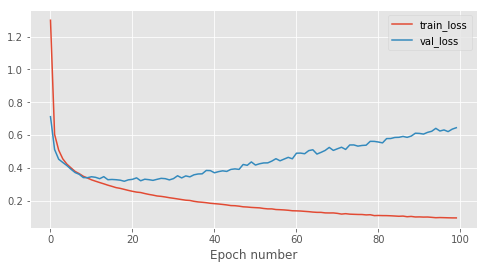

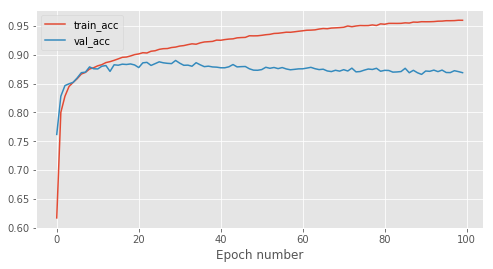

In [5]:
batch_size = 100
image_num_channels = 1
image_height = 28
image_width = 28
dim_reduction_idx = [0,1,2,3]
dim_reduction_type = ['strided_convolution', 'dilated_convolution', 'max_pooling', 'avg_pooling']
num_filters = 64
num_layers = 4
experiment_name = ['strided_convolution_experiment_1', 'dilated_convolution_experiment_1', 'max_pooling_experiment_1', 'avg_pooling_experiment_1']
num_epochs = 100
weight_decay_coefficient = 1e-05
seed = 9112018
use_gpu = True

rng = np.random.RandomState(seed=seed)
train_data = data_providers.EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
val_data = data_providers.EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = data_providers.EMNISTDataProvider('test', batch_size=batch_size, rng=rng)

for reduction_idx,experiment in zip(dim_reduction_idx,experiment_name):
    
    custom_conv_net = ConvolutionalNetwork(
        input_shape=(batch_size, image_num_channels, image_height, image_width),
        dim_reduction_type=dim_reduction_type[reduction_idx],
        num_output_classes=47, num_filters=num_filters, num_layers=num_layers, use_bias=False)

    conv_experiment = ExperimentBuilder(network_model=custom_conv_net,
                                    experiment_name=experiment,
                                    num_epochs=num_epochs,
                                    weight_decay_coefficient=weight_decay_coefficient,
                                    use_gpu=use_gpu,
                                    train_data=train_data, val_data=val_data, test_data=test_data)
    total_losses = conv_experiment.run_experiment()
    print('finish')
    plot_stats_in_graph(total_losses[0])

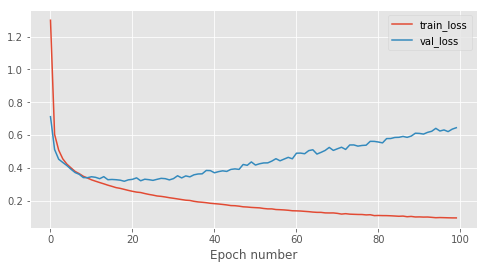

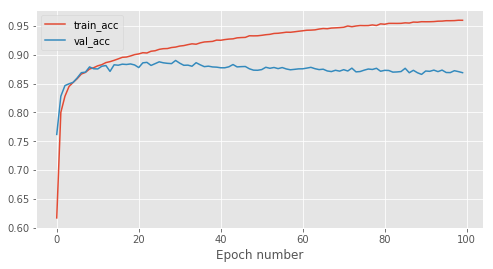

In [6]:
plot_stats_in_graph(total_losses[0])